<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

# Прогнозирование стоимости автомобиля по характеристикам

* Работу выполнили Людмила Григорьева и Юлия Гиль
* Группа DSPR-28
* Дата сдачи 08.09.2021

# <a id="0"></a>Table of Contents

0. [TABLE OF CONTENTS](#0)
1. [IMPORT, FUNCTIONS, SETUP](#1)
2. [DDATA & PRELIMINARY ANALYSIS](#2)
3. [EDA](#3) 
4. [NAÏVE MODEL](#4)
5. [MODEL IMPROVEMENTS](#5)
    * 
6. [SUBMISSION](#6)
7. [SUMMARY](#7)

<a id="1"></a>
# 1. IMPORT, FUNCTIONS, SETUP

In [1]:
#!pip3 install catboost

In [2]:
#pip install pandas-profiling

In [3]:
import numpy as np
import pandas as pd
import sys
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import ttest_ind
from itertools import combinations
from sklearn.feature_selection import f_regression, mutual_info_regression 

%matplotlib inline
warnings.simplefilter('ignore')
sns.set()

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.1


In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы
RANDOM_SEED = 42

## Functions

В данном блоке собраны пользовательские функции.

In [ ]:
def mape(y_true, y_pred):
    """
    Функция возвращает метрику MAPE.
    На вход получает массив реальных и предсказанных значений y.
    """
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
def months_to_sent(months):
    """
    Функция, которая принимает на вход количество месяцев, а возвращает строку в формате "x  месяц(-а -ев)"
    """
    if months == 1:
        return f'{months} месяц'
    elif 2 <= months <= 4:
        return f'{months} месяца'
    return f'{months} месяцев'


def years_to_sent(years):
    if 11 <= years <= 14 or 5 <= years % 10 <= 9 or years % 10 == 0:
        return f'{years} лет'
    elif years % 10 == 1:
        return f'{years} год'
    elif 2 <= years % 10 <= 4:
        return f'{years} годa'


def tenure(row):
    """
    Функция, которая приводит содержимое ячейки "Владение"  train к тому же виду, как в test.
    Вход: строка series (строка колонки).
    Выход: возвращает вместо словаря информацию в виде "x лет y месяцев"
    """
    row = re.findall('\d+', str(row))  # находим все целые числа в строке
    if row != []:
        years = 2020 - (int(row[0])+1)  # 2020, т.к. данные собраны в 2020 году
        months = 2 + (12 - int(row[1]))
        if years < 0:
            return months_to_sent(int(row[1]))
        elif years == 0 and months < 12:
            return months_to_sent(months)
        elif years >= 0 and months == 12:
            return years_to_sent(years + 1)
        elif years >= 0 and months > 12:
            return years_to_sent(years + 1)+' и '+months_to_sent(months - 12)
        elif years > 0 and months < 12:
            return years_to_sent(years)+' и '+months_to_sent(months)
        return None

In [ ]:
def num_of_km(row):
    """
    Функция перевеодит формат данных "y yyy км" в количество месяцев.
    Вход: строка series.
    Выход: количество км.
    """
    if pd.notnull(row):
        # разделяем строку на список из чисел и значения км
        list_km = row.split(' ')
        # print(list_km)
        if len(list_km) == 2:  # если содержится информация в км до 999
            if list_km[1] in ['км']:
                return int(list_km[0])
        return int(list_km[0]+list_km[1])  # км более 1000

In [ ]:
def convert_engineDisplacement_to_float(row):
    row = str(row)
    volume = re.findall('\d\.\d', row)
    if volume == []:
        return None
    return float(volume[0])

In [ ]:
def intitial_eda_checks(df, missing_percent):
    '''
    Функция принимает на вход датафрейм, а также заданный порог % пустых значений, который хотим обработать. 
    На выход выводит на экран информацию о сумме пустых значений для всех колонок, а также проце
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False)
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False)
        percent = mask_percent[mask_percent > 0]

        series = mask_percent[mask_percent > missing_percent]
        columns = series.index.to_list()

        missing_data = pd.DataFrame(pd.concat(
            [total, round(percent*100, 2)], axis=1, keys=['Количество', '%']))
        print('Сумма и процент значений NaN:\n \n')
        display(missing_data)
    else:
        print('NaN значения не найдены.')

In [ ]:
def num_of_months(row):
    """
    Функция перевеодит формат данных "x лет y месяца(ев)" в количество месяцев.
    Вход: строка series.
    Выход: количество месяцев
    """
    if pd.notnull(row) and row != 'no_data':
        list_ownership = row.split()  # разделяем строку на список из месяца и лет
        if len(list_ownership) == 2:  # если содержится информация только про годы
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])  # переводим год в месяцы
        # случай, когда содержится инфо только про месяц
        # прибавляем к годам*12 количетсво месяцев
        return int(list_ownership[0])*12 + int(list_ownership[3])

In [ ]:
def get_boxplot(column):
    """
    Функция для отрисовки коробочной диаграммы для нечисловых признаков.
    На вход получаем список колонок для отрисовки. 
    Отрисовываем относительно целевой переменной pricing, ограниченной по квантилю.
    """
    fig, ax = plt.subplots(figsize=(25, 5))
    plt.subplots_adjust(wspace=0.5)
    sns.boxplot(x=column, y='price',
                data=data[data['train'] == 1],
                ax=ax)
    plt.xticks(rotation=45)
    # поскольку в price много выбросов, огриничимся 75% квантилем
    ax.set_ylim(0, (data.price.quantile(0.75) + 8 *
                    (data.price.quantile(0.75) - data.price.quantile(0.25))))
    ax.set_title('Boxplot для ' + column)
    plt.show()

In [ ]:
def analyze_cat_cols(col):
    fig, axes = plt.subplots(figsize=(25, 5))

    # Посчитаем среднее значение количества объявлений по всем брендам
    mean = data[col].value_counts().values.mean()
    x = data[col].unique()

    sns.histplot(data=data, x=data[col],
                 stat='count', bins=data[col].nunique())
    axes.plot(x, [mean for i in x], '--', color='r')

    # sns.distplot(data['brand'])
    plt.xticks(rotation=45)
    plt.title('Распределение количества объясвлений по '+col)
    plt.show()

    get_boxplot(col)

In [ ]:
def km_per_year(row):
    """
    Функция делает пересчет км пробега автомобиля в года после года производства автомобиля.
    Вход: строка датафрейма.
    Выход: информация о км/год.
    """
    if row['mileage'] != 0:
        # обрабатываем случаи, когда мошина произведена в год сбора данных, чтоб не делить на 0
        if row['parsing_date'].year - row['productionDate'] == 0:
            return row['mileage']
        else:
            return row['mileage']/(row['parsing_date'].year - row['productionDate'])
    return 0  # возвращаем 0, если машина без пробега (новая

In [ ]:
def prod_date_range(row, year_lim):
    """
    Создает столбец с информацией, старше ли авто, чем year_lim.
    Вход: строка, установленный лимит.
    Выход: 1 - если авто старше, 0 - если нет.
    """
    if (row['parsing_date'].year-row['productionDate']) >= year_lim:
        return 1
    return 0

In [ ]:
def iqr_analysis(series, mode=False):
    """
    Функция выводит инфорамцию о границах выборосов для признака.
    Если mode = True, возвращается верхняя и нижняя границы выбросов. Иначе, просто выводится информация на экран.
    """
    IQR = series.quantile(0.75) - series.quantile(0.25)
    perc25 = series.quantile(0.25)
    perc75 = series.quantile(0.75)

    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR

    if mode:
        return f, l

    print(
        "\n25-й перцентиль: {},".format(perc25),
        "\n75-й перцентиль: {},".format(perc75),
        "\nIQR: {}, ".format(IQR),
        "\nГраницы выбросов: [{f}, {l}].".format(
            f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR),
        "\n\nМинимальное значение признака: {}.".format(series.min()),
        "\nМаксимальное значение признака: {} .\n".format(series.max()))

    if series.min() < f:
        print("Найдены выбросы по нижней границе признака! Количество: {}, {}%".format(series.where(
            series < f).count(), round(series.where(series < f).count()/series.count()*100, 2)))
    if series.max() > l:
        print("Найдены выбросы по верхней границе признака! Количество: {}, {}%".format(series.where(
            series > l).count(), round(series.where(series > l).count()/series.count()*100, 2)))

In [ ]:
def get_stat_dif(column):
    """ 
    Поиск статистически значимых различий для колонки с помощью теста Стьюдента.
    """
    cols = data.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))

    tmp = data[data['train'] == 1]

    for comb in combinations_all:
        if ttest_ind(tmp.loc[data[data['train'] == 1].loc[:, column] == comb[0], 'price'],
                     tmp.loc[data[data['train'] == 1].loc[:, column] == comb[1], 'price']).pvalue <= 0.05/len(combinations_all):  # учли поправку Бонферони
            # print('Найдены статистически значимые различия для колонки и комбинаций', column, comb)
            pass
        else:
            print(
                'Не найдены статистически значимые различия для колонки и комбинации', column, comb)
            return column
            break

## Setup

In [ ]:
VERSION = 16
# подключил к ноутбуку внешний датасет
DIR_TRAIN = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
DIR_TEST = '../input/sf-dst-car-price-prediction/'
VAL_SIZE = 0.20   # 20%

<a id="2"></a>
# 2. DATA & PRELIMINARY ANALYSIS

## Data Storage

In [ ]:
!ls '../input'

In [ ]:
# Подключение с Kaggle
""" train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')"""

In [ ]:
# Подключение при работе в Jupyter/Github
# подключение тестового train датасета
train = pd.read_csv('all_auto_ru_09_09_2020.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
train.info()

In [ ]:
test.info()

## Web Data Extracting (auto.ru)

Посмотрим на список колонок, которые есть в test, но нет в подключенном train.

In [ ]:
# Список колонок, которых нет в train
dif_list = list(set(test.columns).difference(train.columns))
print("Список колонок, которых нет в train, но есть в test:", dif_list)

# Посмотрим на данные в этих колонках
test[dif_list].sample(3)

In [ ]:
# Посмотрим на колическтво уникальных значений
for item in dif_list:
    print(item, test[item].nunique())

Выводы:
1. Из информации car_url видим, что данные собирались с сайта auto.ru, будем парсить данные оттуда
2. Следующие поля из test можно не парсить и удалить далее при анализе, т.к. они уникальны для каждой записи: car_url и priceCurrency, т.к. всего одно значение (RUB). Car_url оставим, чтоб можно было посмотреть информацию о машине.
3. Ограничимся для начала двумя вендорами: EUROPEAN, JAPANESE
4. Цену автомобиля собираем в RUB
5. Собираем информацию по полям: 'bodyType', 'brand', 'car_url', 'color', 'complectation_dict', 'description', 'engineDisplacement', 'enginePower', 'equipment_dict','fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name','name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency','productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration','vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС','Привод', 'Руль', 'Состояние', 'Таможня', 'sample', 'price'

Код парсинга новых данных доступе в отдельном ноутбуке.

27.08.2021 нами получен список со ссылками на 137559 объявлений по выбранным маркам автомобилей по всем регионам, 29.08.2021 этот список был обновлен, в результате чего было получено дополнительно еще 133 объявления. В итоге парсинга нами были получены данные для обучающего датасета в размере `137685` записей.

In [ ]:
# Добавим датафрейм с новыми данными
train_new = pd.read_csv('all_car_27_08_2021_data_12_brands.csv', sep=",")

In [ ]:
train_new.info()

In [ ]:
train_new.head()

In [ ]:
# Сразу удалим колонку с дубликатом урал
train_new.drop('Unnamed: 0', axis=1, inplace=True)

# 3. EDA & Basic Data Cleaning

Проведем анализ данных, сделаем базовый препроцессинг данных.

### 3.1 Переименуем колонки с кириллицы на латиницу

In [ ]:
# Переименуем test  колонки
test.rename(columns={"Привод": "drivetrain",
                     "Руль": "driveSide",
                     "Состояние": "condition",
                     "Владельцы": "ownersCount",
                     "ПТС": "tcp",
                     "Таможня": "customs",
                     "Владение": "ownershipTime",
                     "model_name": "model"}, inplace=True)

# Переименуем train  колонки
train.rename(columns={"Привод": "drivetrain",
                      "Руль": "driveSide",
                      "Состояние": "condition",
                      "Владельцы": "ownersCount",
                      "ПТС": "tcp",
                      "Таможня": "customs",
                      "Владение": "ownershipTime"}, inplace=True)

# Переименуем train_new  колонки
train_new.rename(columns={"Привод": "drivetrain",
                          "Руль": "driveSide",
                          "Состояние": "condition",
                          "Владельцы": "ownersCount",
                          "ПТС": "tcp",
                          "Таможня": "customs",
                          "Владение": "ownershipTime",
                          "model_name": "model"}, inplace=True)

### 3.2 Предварительный анализ test данных

Посмотрим на данные в test, которые нужно предсказывать, на особенности данных.

In [ ]:
#ProfileReport(test, title="Pandas Profiling Report for Test Dataset")

Выводы: во время последующего сбора данных и анализа обратить внимание на:
1. Есть пропуски в test данных - нужно попробовать заполнить
2. Представлено всего 12 брендов автомобилей
3. Признаки, которые выглядят бесполезными для моделирования - car_url (уникальный для каждой записи), priceCurrencly (одинаковый у всех)
4. Необходимо разобраться с признаками complectation_dict, description, equipment_dict, model_info, super_gen - посмотреть, можно ли извлечь доп. признаки
5. Condition - у всех "хорошее состояние", обратить внимание, если в train будут записи и другим состоянием, может влиять на выбросы по цене.
6. Customs - у всех "растоможетн", обратить внимание, если в train будут записи и другим состоянием, может влиять на выбросы по цене.

### 3.3 Сравним типы данных в test и train

Найдем расхождения в типах данных для train и test, устраним их до анализа данных.

In [ ]:
# Создадим список с колонками, которые присутствуют и в train, и в test
cols_intersection = list(set(test.columns).intersection(train.columns))

In [ ]:
# Проверим, в каких колонках типы данных различаются у train и test
cols_type_dif = []  # создаем список с колонками, в которых типы данных отличаются
print("Найдены расхождения в типах данных для:")

for col in cols_intersection:
    if type(test[col][0]) != type(train[col][0]):
        print(
            f"\t- колонки {col}: для train - {type(train[col][0])}, для test - {type(test[col][0])}")
        cols_type_dif.append(col)

In [ ]:
# Создадим список с колонками, которые присутствуют и в train, и в test
cols_intersection_2 = list(set(test.columns).intersection(train_new.columns))

In [ ]:
# Проверим, в каких колонках типы данных различаются у train и test
cols_type_dif = []  # создаем список с колонками, в которых типы данных отличаются
print("Найдены расхождения в типах данных для:")

for col in cols_intersection_2:
    if type(test[col][0]) != type(train_new[col][0]):
        print(
            f"\t- колонки {col}: для train_new - {type(train_new[col][0])}, для test - {type(test[col][0])}")
        cols_type_dif.append(col)

**ownersCount**

Количество владельцев автомобиля (1 - один, 2 - два, 3 - 3 и более).

In [ ]:
print("Уникальные значения для train", train.ownersCount.unique())
print("Уникальные значения для train_new", train_new.ownersCount.unique())
print("Уникальные значения для test", test.ownersCount.unique())

Преобразуем значения test, train_new в числовые (float).

In [ ]:
# Создаем словать с кодировкой значений в числовые
ownersCount_dict = {"3 или более": 3.,
                    "1\xa0владелец": 1., "2\xa0владельца": 2.}
test['ownersCount'].replace(
    to_replace=ownersCount_dict, inplace=True)  # заменяем значения в соответствии со словарем

In [ ]:
ownersCount_dict = {
    "1 владелец": 1., "2 владельца": 2., "3 или более": 3.}
train_new['ownersCount'].replace(
    to_replace=ownersCount_dict, inplace=True)  # заменяем значения в соответствии со словарем

In [ ]:
# Проверяем результаты преобразования
print("Уникальные значения для test", test.ownersCount.unique())
print("Уникальные значения для train_new", train_new.ownersCount.unique())

**enginePower**

Мощность л.с.

In [ ]:
print("Пример значения для train", train.enginePower.sample(1).values)
print("Пример значения для train_new", train_new.enginePower.sample(1).values)
print("Пример значения для test", test.enginePower.sample(1).values)

Преобразуем значения test, train_new в числовые (float).

In [ ]:
# Преобразовываем значения столбца, избавляемся от постфика N12
test['enginePower'] = test['enginePower'].apply(
    lambda x: float(x.split(" ")[0]))
train_new['enginePower'] = train_new['enginePower'].apply(
    lambda x: float(x.split(" ")[0]))

In [ ]:
# Посмотрим на результат преобразования
print("Пример значения для test", test.enginePower.sample(1).values)
print("Пример значения для train_new", train_new.enginePower.sample(1).values)

**numberOfDoors**

Количество дверей.

In [ ]:
print("Уникальные значения для train", train.numberOfDoors.unique())
print("Уникальные значения для train_new", train_new.numberOfDoors.unique())
print("Уникальные значения для test", test.numberOfDoors.unique())

Значения аналогичны, целые числа, приведем в train к int.

In [ ]:
# Конвертируем в int
train['numberOfDoors'] = train['numberOfDoors'].astype('Int64')

**customs**

Информация, растоможен ли автомобиль: 0 - не растоможен, 1 - растоможен.

In [ ]:
print("Уникальные значения для train", train.customs.unique())
print("Уникальные значения для train_new", train_new.customs.unique())
print("Уникальные значения для test", test.customs.unique())

Поскольку далее для моделирования нам понадобится числовая переменная, то сразу переведем в числовую 0 - не растоможен, 1 - растоможен, как для train, так и для test.

In [ ]:
# Делаем преобразование значений в int (0 или 1)
train['customs'] = train['customs'].apply(lambda x: 1 if x == True else 0)
test['customs'] = test['customs'].apply(
    lambda x: 1 if x == "Растаможен" else 0)
train_new['customs'] = train_new['customs'].apply(
    lambda x: 1 if x == "Растаможен" else 0)

**condition**

Состояние автомобиля: 0 - не требует ремонта , 1 - требует ремонта.

In [ ]:
print("Уникальные значения для train", train.condition.unique())
print("Уникальные значения для train_new", train_new.condition.unique())
print("Уникальные значения для test", test.condition.unique())

Поскольку далее для моделирования нам понадобится числовая переменная, то сразу переведем в числовую 0 - требует ремонта , 1 - не требует ремонта, как для train, так и для test.

In [ ]:
# Делаем преобразование значений в int (0 или 1)
train['condition'] = train['condition'].apply(lambda x: 0 if pd.isna(x) else 1)
test['condition'] = test['condition'].apply(
    lambda x: 0 if x == "Не требует ремонта" else 1)
train_new['condition'] = train_new['condition'].apply(
    lambda x: 0 if x == "Не требует ремонта" else 1)

**modelDate**

Год выпуска модели автомобиля.

In [ ]:
print("Уникальные значения для train", train.modelDate.unique())
print("Уникальные значения для train_new", train_new.modelDate.unique())
print("Уникальные значения для test", test.modelDate.unique())

Годы - целые числа. Преобразуем train данные в int.

In [ ]:
train['modelDate'] = train['modelDate'].astype('Int64')

**ownershipTime**

Вемя владения автомобилем. 

Несмотря на то, что тип данных совпадает, формат хранения информации в train и test отличается.

In [ ]:
# Применяем функцию по очистке данных и приведению их к такому же виду, как в test выборке.
train['ownershipTime'] = train['ownershipTime'].apply(tenure)

In [ ]:
train['ownershipTime'] = train['ownershipTime'].fillna('no_data')

**mileage**

Пробег. Для данных в train_new указаны км и есть пробелы, нужно привести к числовому формату.

In [ ]:
print("Пример значения для train",
      train[train['mileage'].isnull() == False]['mileage'].sample(1).values)
print("Пример значения для train_new",
      train_new[train_new['mileage'].isnull() == False]['mileage'].sample(1).values)
print("Пример значения для test",
      test[test['mileage'].isnull() == False]['mileage'].sample(1).values)

In [ ]:
train_new['mileage'] = train_new['mileage'].apply(num_of_km)

**engineDisplacement**

Объем двигателя в литрах, нужно привести к общему формату во всех датасетах.

In [ ]:
print("Пример значения для train", train[train['engineDisplacement'].isnull(
) == False]['engineDisplacement'].sample(1).values)
print("Пример значения для train_new", train_new[train_new['engineDisplacement'].isnull(
) == False]['engineDisplacement'].sample(1).values)
print("Пример значения для test", test[test['engineDisplacement'].isnull(
) == False]['engineDisplacement'].sample(1).values)

_train['engineDisplacement']_

Необходимо вытащить мощность из текущего поля, но извлечь из engineDisplacement не получится, зато вся информация есть в поле name, где после строкового названия перечислен объем в формате числа с точкой (.). 

In [ ]:
train['engineDisplacement'] = train['name'].apply(
    convert_engineDisplacement_to_float)

In [ ]:
# Сразу проверим пропуски
len(train[train['engineDisplacement'].isna()])

In [ ]:
train[train['engineDisplacement'].isna()].fuelType.unique()

_train_new['engineDisplacement'], test['engineDisplacement']_

Избавимся от LTR в наименовании объема двигателя и конвертируем во float.

In [ ]:
train_new['engineDisplacement'] = train_new['engineDisplacement'].apply(
    convert_engineDisplacement_to_float)

test[test['engineDisplacement'] == ' LTR']['engineDisplacement'].replace(
    " LTR", "0.0 LTR", inplace=True)
test['engineDisplacement'] = test['engineDisplacement'].apply(
    convert_engineDisplacement_to_float)

### 3.4 Совмещаем test, train, train_new для обработки и анализа

До совмещения test и train посмотрим, какие признаки можем извлечь из test/train, помимо колонок, которые в явном виде пересекаются между датафреймами.

In [ ]:
# Список колонок, которых нет в train, но есть в test
dif_list_test = list(set(test.columns).difference(train.columns))
print("Список колонок, которых нет в train, но есть в test:", dif_list_test)

# Посмотрим на данные в этих колонках
print("\nTEST DF:")
test[dif_list_test].sample(3)

In [ ]:
# Список колонок, которых нет в test, но есть в train
dif_list_train = list(set(train.columns).difference(test.columns))
print("Список колонок, которых нет в test, но есть в train:", dif_list_train)

# Посмотрим на данные в этих колонках
print("\nTRAIN DF:")
train[dif_list_train].sample(3)

In [ ]:
# Список колонок, которых нет в train_new, но есть в test
dif_list_test_new = list(set(test.columns).difference(train_new.columns))
print("Список колонок, которых нет в train_new, но есть в test:", dif_list_test_new)

# Посмотрим на данные в этих колонках
print("\nTEST DF:")
test[dif_list_test_new].sample(3)

In [ ]:
# Список колонок, которых нет в test, но есть в train
dif_list_train_new = list(set(train_new.columns).difference(test.columns))
print("Список колонок, которых нет в test, но есть в train_new:", dif_list_train_new)

# Посмотрим на данные в этих колонках
print("\nTRAIN DF:")
train_new[dif_list_train_new].sample(3)

Идеи для обогощений датасетов, чтобы получить общие данные для работы:
- [x] Train, Train_new: добавить колонку vendor, можно создать словарик соответсвия brand-vendor
- [x] Train, Train_new: model_name важная информация, нужно получить колонку. В train такая колонка есть - называется model. Унифицировать имена, привести к model (переименовать в test). Переименование добавлено выше в код, где переименовывались колонки.
- [x] All: поскольку все данные парсились в разное время, то добавим колонку parsing_date для всех датафреймов.

Также дополнительно в TEST найдено:
- В признаке super_gen можно дополнительно доставть 1) acceleration (скорость разгона) 2) clearance_min 3) fuel_rate (расход топлива)
- В признаке equipment_dict лежит полезная информация про комплектацию автомобиля. Посмотреть, есть ли что-то похожее в Train.

**Добавляем vendor в train**

In [ ]:
# Создаем словарь из вендоров по брендам
vendor_dict = test.groupby(['vendor'])['brand'].apply(
    lambda grp: list(grp.value_counts().index)).to_dict()
vendor_dict

In [ ]:
# Список брендов, которых нет в test, но есть в train
dif_list_brands = list(
    set(train.brand.unique()).difference(test.brand.unique()))
print("Список колонок, которых нет в test, но есть в train:", dif_list_brands)

In [ ]:
# Добавим в словарь vendor_dict недостающие бренды по существующим ключам
eur_append = ['PORSCHE', 'LAND_ROVER', 'JAGUAR',
              'MINI', 'RENAULT', 'OPEL', 'PEUGEOT', 'CITROEN']
jap_append = ['SUBARU', 'MAZDA', 'SUZUKI']

for brand in eur_append:
    vendor_dict['EUROPEAN'].append(brand)
for brand in jap_append:
    vendor_dict['JAPANESE'].append(brand)

In [ ]:
# Добавляем новые ключи
vendor_dict.update({'AMERICAN': ['CHEVROLET', 'CHRYSLER', 'CADILLAC', 'JEEP', 'FORD', 'DODGE'],
                    'ASIAN': ['HYUNDAI', 'DAEWOO', 'KIA', 'CHERY', 'SSANG_YONG', 'GEELY', 'GREAT_WALL']})

In [ ]:
# Смотрим итоговый словарь
print(vendor_dict)

In [ ]:
# Создадим новый словарь для мапинга
new_map = {str(x): str(k) for k, v in vendor_dict.items() for x in v}

In [ ]:
# Создаем признак vendor в train
train['vendor'] = train.brand.copy()
train['vendor'] = train['vendor'].map(new_map)

In [ ]:
# Создаем признак vendor в train
train_new['vendor'] = train_new.brand.copy()
train_new['vendor'] = train_new['vendor'].map(new_map)

**Добавляем parsing_date во все датасеты**

- test: берем признак из parsing_unixtime
- train: берем признак из имени файла (09.09.2020)
- train_new: берем признак из parsing_unixtime

In [ ]:
# Добавляем фиксированную дату в train
train['parsing_date'] = '2020-09-09'
train['parsing_date'] = pd.to_datetime(train['parsing_date'])

In [ ]:
# Добавляем колонку из unixtime в test, train_new
train_new['parsing_date'] = pd.to_datetime(
    train_new.parsing_unixtime, unit='s')
train_new['parsing_date'] = pd.to_datetime(
    train_new['parsing_date']).dt.floor('d')

test['parsing_date'] = pd.to_datetime(test['parsing_unixtime'], unit='s')
test['parsing_date'] = pd.to_datetime(test['parsing_date']).dt.floor('d')

In [ ]:
# Поскольку это служебный признак, то мы его сразу добавляем в список на удаление
# Создадим список и добавим колонки, которые планируем удалить по результатам предварительного анализа
cols_removal = ['parsing_date']

После завершения подготовительного этапа склеиваем два датафрейма.

In [ ]:
# Для анализа склеиваем оба датафрейма по общим колонкам, добавляем признак sample
train['train'] = 1  # помечаем где у нас трейн
train_new['train'] = 1  # помечаем где у нас трейн
test['train'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения цены, мы его должны предсказать, поэтому пока просто заполняем нулями
test['price'] = 0
train['sell_id'] = 0  # поле понадобавиться для сабмита, оставляем
train_new['sell_id'] = 0  # поле понадобавиться для сабмита, оставляем

data = pd.concat([train, test, train_new], axis=0,
                 join="inner", ignore_index=True)

In [ ]:
# Посмотрим, что получилось
data.info()

In [ ]:
# Преобразуем modelDate в int
data['modelDate'] = data['modelDate'].astype('Int64')

In [ ]:
data.sample(3)

Проведем предварительный анализ данных.

In [ ]:
# Запустим библиотеку для предварительного анализа данных
#ProfileReport(data, title="Pandas Profiling Report for Merged Test and Train Datasets")

Выводы:
1. Суммарно 261749 строки, 6.1% пропусков, 53.1 дубликатов. Данные достаточно "чистые", пригодны для работы.
2. В датасете 27 признаков. Типы переменных: числовых - 7, категориальных - 18, неопределенный - 1.
3. Идеи по очистке данных в колонках и вопросы для анализа данных:
    - bodyType - убрать верхний и нижний регистр, сократить кол-во категорий, убрать информацию о количестве дверей, тк есть отдельный признак numberOfDoors.
    - color	- коды перевести в цвета
    - fuelType - разобраться, что такое универсал
    - vehicleTransmission - рус и англ варианты унифицировать
    - numberOfDoors - разобраться с транспортом 0 дверей
    - driveSide	- рус и англ варианты унифицировать
    - tcp - рус и англ варианты унифицировать
    - description - кандидат на удаление, но можно извлечь новые признаки
    - ownershipTime - кандидат на удаление, т.к. много пропусков
    - price - есть пропуски, т.к. целевая переменная не заполняем, а удаляем строки.
 
4. Признаки-кандидаты на удаление:
    - vehicleConfiguration - дублирует информацию из колонок vehicleTransmission, engineDisplacement, bodyType. Удалить признак после обработки пропусков.
    - name - дублирует информацию из колонок engineDisplacement, vehicleTransmission, enginePower, drivetrain. Удалить признак после обработки пропусков
5. price - есть пропущенные значения, удалить строки из обучающей выборки.
6. Корреляционный анализ:
     - есть колинеарные признаки:
         - (productionDate - modelDate, mileage - modelDate/productionDate, ownersCount - modelDate/productionDat). Логично, что дата модели и дата производства связаны, также чем старше машина, тем больше пробег и тем большее количетсво владельцев авто)
         - conditions, customs - некорретные коэффициенты, нужно анализировать.
7. Наибольшее количество пропусков в колонках ownershipCount, ownersCount. Можно попробовать предсказать количество, исходя из даты выпуска (т.к. признаки скоррелированы).

Создадим список, в который будем добавлять колонки-кандидаты на удаление из датасета.

In [ ]:
# Создадим список и добавим колонки, которые планируем удалить по результатам предварительного анализа
cols_removal.append('vehicleConfiguration')
cols_removal.append('name')

### 3.5 Базовая чистка данных

Проведем чистку и дополнительную подготовку данных, исходя из идей выводов выше (пункт 3).

- [x] color	- коды перевести в цвета
- [x] vehicleTransmission - рус и англ варианты унифицировать
- [x] driveSide	- рус и англ варианты унифицировать
- [x] tcp - рус и англ варианты унифицировать
- [x] bodyType - привести к нижнему регистру, т.к. часть данных указаны по разному.

**vehicleTransmission**

Информация про коробку передач.

In [ ]:
data.vehicleTransmission.value_counts()

Посмотрим на значения на auto.ru. Все коробки делятся на автомат и механику. Автомат подразделяется на варианты.
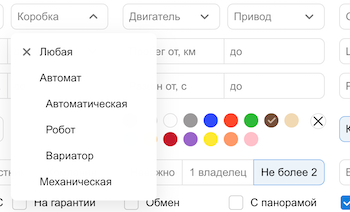

Создадим из данного признака новый признак:
- коробка передач (автомат, механика)

In [ ]:
# Создаем колонку transmission со значениями "автомат" и "механическая"
data['transmission'] = data.vehicleTransmission.copy()

data['transmission'].replace(['AUTOMATIC', 'ROBOT', 'VARIATOR',
                              'роботизированная', 'автоматическая', 'вариатор'], "автомат", inplace=True)
data['transmission'].replace(
    ['MECHANICAL', 'механическая'], "механическая", inplace=True)

In [ ]:
# В колонке vehicleTransmission почистим данные значениями 'робот', 'автоматическая', 'вариатор' или "механическая"

data['vehicleTransmission'].replace(
    ['AUTOMATIC', 'автоматическая'], "автоматическая", inplace=True)
data['vehicleTransmission'].replace(
    ['ROBOT', 'роботизированная', ], "робот", inplace=True)
data['vehicleTransmission'].replace(
    ['VARIATOR', 'вариатор'], "вариатор", inplace=True)
data['vehicleTransmission'].replace(
    ['MECHANICAL', 'механическая'], "механическая", inplace=True)

In [ ]:
# Проверим, какие значения получились
print(data['transmission'].unique())
print(data['vehicleTransmission'].unique())

**color**

Цвет автомобиля.

In [ ]:
# Посмотрим на представленные цвета
data.color.unique()

In [ ]:
# Создаем словать с кодировкой значений в цвета
color_dict = {'040001': 'чёрный', 'EE1D19': 'красный', '0000CC': 'синий', 'CACECB': 'серебристый', '007F00': 'зелёный',
              'FAFBFB': 'белый', '97948F': 'серый', '22A0F8': 'голубой', '660099': 'пурпурный', '200204': 'коричневый',
              'C49648': 'бежевый', 'DEA522': 'золотистый', '4A2197': 'фиолетовый', 'FFD600': 'жёлтый',
              'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}

data['color'].replace(to_replace=color_dict, inplace=True)

In [ ]:
# Проверяем результат
data.color.unique()

**driveSide**

Расположение руля

In [ ]:
data.driveSide.unique()

In [ ]:
# Заменим анлоязычные значения на русские
data['driveSide'] = data['driveSide'].map(
    {'RIGHT': 'Правый', 'LEFT': 'Левый', 'Правый': 'Правый', 'Левый': 'Левый'})

In [ ]:
# Уберем верхний регистр
data['driveSide'] = data['driveSide'].str.lower()

In [ ]:
# Проверяем результат
data.driveSide.unique()

**tcp**

Оригинал ПТС

In [ ]:
data.tcp.unique()

In [ ]:
data[data.train == 0].tcp.head()

In [ ]:
# Заменим анлоязычные значения на русские
data['tcp'] = data['tcp'].map(
    {'ORIGINAL': 'Оригинал', 'DUPLICATE': 'Дубликат', 'Оригинал': 'Оригинал', 'Дубликат': 'Дубликат'})

In [ ]:
# Уберем верхний регистр
data['tcp'] = data['tcp'].str.lower()

In [ ]:
# Проверяем результат
data.tcp.unique()

**bodyType**

Тип кузова.

In [ ]:
data.bodyType.value_counts()

In [ ]:
# Приведем значения к нижнему регистру, уберем ряд дубликатов в значениях
data['bodyType'] = data['bodyType'].apply(lambda x: str(x).lower())

Огромное количество категорий, многие категории представлены единичными автомобилями => переструктурировать категории, уменьшить их количество, провести повторный анализ.

In [ ]:
# Заменяем весь "зоопарк" типов кузова на основные, согласна поиску по типу кузова на auto.ru
data['bodyType'].replace(regex={r'внедорожник.*': 'внедорожник',
                                r'седан.*': 'седан',
                                r'хэтчбек.*': 'хэтчбек',
                                r'купе.*': 'купе',  r'тарга.*': 'тарга', r'микровэн.*': 'микровэн',
                                r'пикап.*': 'пикап', r'родстер.*': 'родстер',
                                r'универсал.*': 'универсал', r'лифтбек.*': 'лифтбек',
                                r'минивэн.*': 'минивэн', r'компактвэн.*': 'компактвэн',
                                r'лимузин.*': 'лимузин', r'фургон.*': 'фургон', r'кабриолет.*': 'кабриолет'
                                },
                         inplace=True)

In [ ]:
print("Уникальные значения типа кузова после очистки:", data.bodyType.unique())

In [ ]:
# Посмотрим на результи
pd.DataFrame(data['bodyType'].value_counts(normalize=True))

### 3.6 Дубликаты

Определим количество дубликатов в данных в части train.

In [ ]:
print("Количество дубликатов строк в train части датафрейма:",
      data[data.train == 1].duplicated().sum())

In [ ]:
# Удалим дубликаты из датасета
data.drop_duplicates(inplace=True)

In [ ]:
print(f"Для анализа осталось {len(data)} записей.")

### 3.7 Анализ пропусков

Посмотрим вцелом на наличие пустых значений и определим стратегию работы с ними.

In [ ]:
# Запускаем функцию вывода всех пустых значений
print("Пропуски для TEST+TRAIN датафрейов.\n")
intitial_eda_checks(data, 0)

In [ ]:
print("Пропуски для TEST датафрейма.\n")
intitial_eda_checks(data[data.train == 0], 0)

In [ ]:
# Посмотрим, как распределены пропуски в части train
ax = plt.axes()
sns.heatmap(data[data.train == 1].isnull(),
            yticklabels=False, cbar=False, cmap='Blues')
ax.set_title('Распределение пропусков в TRAIN')
plt.show()

In [ ]:
# Посмотрим, как распределены пропуски в части test
ax = plt.axes()
sns.heatmap(data[data.train == 0].isnull(),
            yticklabels=False, cbar=False, cmap='Blues')
ax.set_title('Распределение пропусков в TEST')
plt.show()

В таблице выведена информация по всем пустым значениям для всех столбцов основного рабочего датасета (data).

Выводы и стратегия обработки:
1. В 17 столбцах присутствуют пропуски.
2. Test:
    - [x] tcp: пропуск в одной записи, посмотреть на нее детально, попробовать восстановить или заполнить модой
    - [x] ownershipTime: много пропусков (около 65%), проанализировать с чем скоррелирован признак, попробовать заполнить. Если заполнить не получится, то возможно, удалить из признаков для моделирования.
3. Train + Test:
    - [x] ownersCount (11111) - можно построить мапинг с медианой/модой по группам в зависимости от года выпуска авто. 
    - [x] price (742) - значения с пропусками удалить из данных 
    - [x] tcp (844) - поисследовать пропуски и подумать над способами заполнения.
    - [x] есть ряд столбцов, где присутсвует ровно один пропуск или одинаковое количество. Проверить гипотезу, что пропуски находятся в одной и той же строке.
    - [x] description заполнить не удастся, колонка в таком виде, как есть, будет удаляться.

Займемся обработкой пропусков по описанной выше стратегии.

**price**

In [ ]:
# Проверим, что price отсуствует именно в train данных и мы не затроним test
data[data.price.isnull() == True]['train'].value_counts()

In [ ]:
# Удаляем строки с price = NAN
data.dropna(subset=['price'], inplace=True)

**Гипотеза, что NAN с одной строкой - это одна и та же запись**

In [ ]:
# Посмотрим на запись
data[data.modelDate.isnull() == True]

In [ ]:
# Посмотрим, что за строка, где modelDate = NaN
print("Индекс строки к удалению:",
      data[data.modelDate.isnull() == True].index[0])

Действительно, в одной строке очень много пропусков, при этом машина 1989, недорогая. Удаляем.

In [ ]:
# Удаляем строку
data.drop([24624], inplace=True)

Посмотрим таким же споосбом на 495 строк, где есть пропуски по 'mileage', drivetran, model, driveSide.

In [ ]:
# Посмотрим на записи
print("Даты парсинга объясвлений:",
      data[data.mileage.isnull() == True]['parsing_date'].unique())
print("Длина датафрейма с пустыми 'mileage', drivetran, model, driveSide:", len(data[(data.mileage.isnull() == True) &
                                                                                     (data.drivetrain.isnull() == True) &
                                                                                     (data.model.isnull() == True) &
                                                                                     (data.driveSide.isnull() == True)]))

Гипотеза подтвердилась, в принципе можно заполнить все пропуски достаточно точно, за исключение mileage, но пока исключим строки из анализа.

In [ ]:
# Удалим строки с пропусками
data.drop(data[(data.mileage.isnull() == True) &
               (data.drivetrain.isnull() == True) &
               (data.model.isnull() == True) &
               (data.driveSide.isnull() == True)].index, inplace=True)

**tcp**

Проверим гипотезу, что:
- tcp пустой у новых машин
- tcp пустой там, где это дубликат.

In [ ]:
# Посмотрим на пример таких данных
data[data.tcp.isnull() == True].sample(3)

In [ ]:
# Сгруппируем данные по году выпуска и выведем медианный пробег и кол-во владельцев
data[data.tcp.isnull() == True].groupby('productionDate')[
    'mileage', 'ownersCount'].median()

Действительно, выглядит так, что NAN - для новых машин и одной машины с теста. 
Стратегия заполнения:
- для новых авто: оставляем "оригинал", но добавляем признак, "новое авто"
- для 10412 из test: попробуем "дубликат"

In [ ]:
# Заполняем test значением дубликат
data.tcp.loc[data[(data.tcp.isnull() == True) & (
    data.train == 0)]['tcp'].index[0]] = 'дубликат'

In [ ]:
# Смотрим, какой mileage у оставшихся записей. Удостоверимся, что это авто без пробега
data[data.tcp.isnull() == True].mileage.value_counts()

In [ ]:
# Заполняем значением "новое авто"
data.tcp.fillna('оригинал', inplace=True)

In [ ]:
# Проверяем, что получилось
data.tcp.value_counts()

**description**

Пропуски заполнить проблематично, перед постраением модели признак удалим, пока оставим. Идея для нового признака - наличие описания (да/нет).

In [ ]:
# добавим колонку в список на удаление перед построением модели
cols_removal.append('description')

**OwnershipTime**

Попробуем восстановить информацию о времени владении, исходя из информации в productionDate.

Создадим на базе признака колонку, в которой поместим информацию о количестве месяцев владения автомобилем.

In [ ]:
# Создаем новый столбец с количеством месяцев владения
data['ownershipTimeMonths'] = data['ownershipTime'].apply(num_of_months)

In [ ]:
# Пока заполняем пропуски no_data, далее решаем, что сделать с признаком
data['ownershipTime'] = data['ownershipTime'].fillna('no_data')

In [ ]:
# Смотрим, что получилось
data[data.ownershipTime != 'no_data'][[
    'ownershipTime', 'ownershipTimeMonths']].sample(5)

У 65% записей данные о времени владении отсутсвует. Проверим гипотезу, что есть какая-то взаимосвязь между ownershipTimeMonths и productionDate. Поисследуем, чтобы посмотреть, можем ли заполнить пропуски.

In [ ]:
# Извлечм орипнтировочную информацию о количестве месяцев после производства
data['prodTimeMonths'] = data.apply(lambda x: (
    x['parsing_date'].year - x['productionDate'])*12, axis=1)

In [ ]:
# Посмотрим, как распределены статистики по признакам
data[(data.ownershipTimeMonths.isnull() == False) & (
    data.productionDate != 2020)][['prodTimeMonths', 'ownershipTimeMonths']].describe()

In [ ]:
# Добавим признак, показывающий во сколько раз время после производства больше времени владения
data['prodTime_ownershipTime'] = data.apply(
    lambda x: x['prodTimeMonths']/x['ownershipTimeMonths'], axis=1)

In [ ]:
# Посмотрим статистики
data.prodTime_ownershipTime.describe()

In [ ]:
# Посмотрим на графики
fig, ax = plt.subplots(figsize=(10, 5))
#sns.scatterplot(data=data, x='prodTimeMonths', y="prodTime_ownershipTime")
ax.set_title('Распределение prodTime_ownershipTime во времени')
plt.show()

In [ ]:
# Посмотрим на распределение признака
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(data['prodTime_ownershipTime'])
ax.set_title('Распределение prodTime_ownershipTime')
plt.show()

Видно, что есть какая-то группировка признака по классам, но пока не понятно, на базе какого признака наблюдается линейная зависимость по коэффициентам соотношения времени владения и времени после производства.

Следующие шаги:
1. План-минимум: заполнить для новых авто NAN нулями, внести признак, что время владения не указано. Возможно, что-то из этого получится. Текущий признак удалить.
2. План-максимум: найти, каким образом заполнить недостающие значения.

In [ ]:
# Заполним нулями признак для новых автомобилей
data['ownershipTimeMonths'].loc[(data['mileage'] == 0) & (
    data['ownershipTimeMonths'].isnull() == True)] = 0

In [ ]:
# Удалим служебные признаки, которые создавали для вычислений
data.drop(['prodTime_ownershipTime', 'prodTimeMonths'], axis=1, inplace=True)

In [ ]:
# Добавим исходную колонку в список на удаление перед построением модели
cols_removal.append('ownershipTime')
cols_removal.append('ownershipTimeMonths')

**ownersCount**

Количество владельцев.

In [ ]:
# Все пропуски по значению находятся в train части
data[data.ownersCount.isnull() == True].train.value_counts()

In [ ]:
# Посмотрим по данным с незаполненным количетсвом владельцев медианные значения метрик.
data[data.ownersCount.isnull() == True].groupby('productionDate').median()

Интересно: пробег везде по 0. Посомтрим уникальные значения пробега по отфильтрованным данным.

In [ ]:
data[data.ownersCount.isnull() == True]['mileage'].describe()

Всё явно, владельцы не заполнены, потому что это новые авто. Заполняем пропуски 0.

In [ ]:
# Заполняем пропуски 0
data['ownersCount'].fillna(0, inplace=True)

In [ ]:
# Приведем значение признака из float в int
data['ownersCount'] = data['ownersCount'].astype('int64')

### 3.8 Детальный анализ признаков

#### Группировка признаков на категориальные, бинарные и числовые

Посмотрим, какие признаки могут относиться к категориальным, бинарным, числовым.

In [ ]:
# Посмотрим, сколько уникальных значений
print("Количество уникальных категорий в признаках.")
data.nunique(dropna=False)

In [ ]:
# Выведем пример признаков на экран
print("Выведем пример значений признаков одной из записей датасета.")
data.loc[5]

In [ ]:
# Посмотрим, на колонки, которые планируем в последствие удалить, чтобы не включать их в анализ
print("Признаки для последующего удаления:", cols_removal)

In [ ]:
# Создадим списки с разными категориями признаков
# бинарные признаки
bin_cols = ['condition', 'customs', 'driveSide', 'transmission', 'tcp']

# категориальные переменные
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'drivetrain',
            'model', 'vendor', 'vehicleTransmission', 'numberOfDoors', 'ownersCount']

# числовые переменные
num_cols = ['modelDate', 'productionDate',
            'enginePower', 'mileage', 'engineDisplacement']

# сервисные переменные
service_cols = ['train', 'sell_id', 'parsing_date']

# целевая переменная
target_col = ['price']

all_cols = bin_cols + cat_cols + num_cols + service_cols + target_col

print("Кол-во столбцов, для дальнейшей работы после предварительного анализа:", len(all_cols))

#### Числовые переменные: распределение, корреляционный анализ, определение значимости

###### Распределние численных признаков.

In [ ]:
"""  
# Построим распределение основных числовых признаков

print("Диаграмы распределения числовых признаков, взаимосвязь с целевой переменной")

fig, axes = plt.subplots(5, 3, figsize=(30, 40))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in num_cols:
    sns.distplot(data[col], ax=axes[i])
    i = i + 1
    sns.boxplot(data[col], ax=axes[i])
    i = i + 1
    sns.scatterplot(data=data[data['train'] == 1],
                    x=col, y="price", ax=axes[i])
    i = i + 1
"""

In [ ]:
print("Основные статистики для числовых признаков.")
display(data[num_cols].describe())

Выводы:

1. После построения гистограмм стало очевидно, что распределения основных числовых переменных имеют тяжёлый левый или правый хвост, влияет на разбежку между средним и медианой: 
    - для того, чтобы сделать распределение данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных
    - поработать с выбросами
    - подумать про группировку признаков по категориям.
2. Распределние modelDate, productionDate очень схожи:
    - проверить на признаки на мультиколлинеарность во время корреляционного анализа
    - видно, что в среднем productionDate чуть позже, чем modelDate во времени, т.е. производство приосходит чуть с запозданием, что логично. Можно добавить новый признак - насколько новая модель, т.е. через сколько лет после появления модели был выпущен автомобиль.
3. mileage: есть пик в 0 - признак нового авто.
4. enginePower: 11 лс - что это за авто? Поисследовать
5. engineDisplacement: основная масса авто - 2.0 л, есть разброс.
5. Взаимосвязь признаков с таргетом:
    - наблюдается прямая корреляция цены от года модели и года выпуска с исключениями для особо раритетных автомобилей (~до 1975 года).
    - наблюдается обратная корреляция цены от пробега авто
    - цена от мощности вдигателя и объема двигателя зависит, но не так явно, как от других переменных.

###### Корреляционный анализ.

Оценим корреляцию Пирсона для непрерывных переменных. Cильная корреляция между переменными вредна для линейных моделей из-за неустойчивости полученных оценок.

In [ ]:
# Построим матрицу корреляций
heatmap = sns.heatmap(data[num_cols + target_col].corr(), vmin=-1,
                      vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций')
plt.show()

Вывод: 
1. Взаимосвязь пар числовых признаков по Пирсону достаточно сильная для productionDate, modelDate. При этом, у productionDate чуть большая корреляция с целевой переменной. Удалим признак modelDate.
2. Достаточно сильная корреляция между productionDate и meleage - чем меньше год выпуска, тем больше пробег
3. engineDisplacement и enginePower достаточно сильно скоррелированы (0.84). Для моделирования оставить один признак - enginePower, т.к. он сильнее влияет на price.
4. У всех числовых признаков достаточно высокая корреляция с целевой переменной, это хорошо.

In [ ]:
# Добавляем modelDate в список колонок на удаление.
cols_removal.append('modelDate')
cols_removal.append('engineDisplacement')

###### Дополнительный анализ числовых признаков

Посмотрим более пристально на признаки, которые не исключили из анализа.

**mileage**

Дополнительно поисследуем признак.

In [ ]:
# Посмотрим на топ 5 годов выпуска авто
fig, ax = plt.subplots(figsize=(10, 5))

for x in (data['productionDate'].value_counts())[0:7].index:
    data['mileage'][data['productionDate'] == x].hist(bins=50)

ax.set_xlim(0, 700000)
ax.set_ylim(0, 1750)

plt.title("Распределение mileage по productionDate")
plt.show()

Получается, что mileage имеет нормальное распределение, просто чем старше автомобиль, тем больше пробег, из-за мы видим смещение.

Чтобы скорректировать признак и сделать его более информативным создадим новый признак в разделе создания признаков: km_per_year - показывает, сколько км в год проезжал автомобиль. Вычисляется, как mileage/productionDate(years) или mileage/ownershipTime. Решить, какой метод использовать.

**enginePower**

Нужно поисследовать странное минимальное значение мощности.

In [ ]:
print("Значение мощности двигателя (л.с.) на TEST")
display(data[data.train == 0]['enginePower'].describe())

print("\nЗначение мощности двигателя (л.с.) на TRAIN")
display(data[data.train == 1]['enginePower'].describe())

Видим, что в Test минимум - больше, а максимум - меньше. Посмотрим, что это за авто и сколько их.

In [ ]:
print("Строки, в которых мощность двигателя меньше 30 л.с.")
data[data.enginePower < data[data.train == 0]['enginePower'].min()]

In [ ]:
print("Строки, в которых мощность двигателя более 639 л.с.")
data[data.enginePower > data[data.train == 0]['enginePower'].max()]

Таких строк немного, удалим из из дальнейшего анализа. Более того, большинство записей не входят в список 12 брендов из test выборки.

In [ ]:
# Таких строк немного, удалим из из дальнейшего анализа
data.drop(data[(data.enginePower > data[data.train == 0]
                ['enginePower'].max()) | (data.enginePower < data[data.train == 0]
                                          ['enginePower'].min())].index, inplace=True)

**productionDate/modelDate**

Посмотрим повнимательнее на признак и попробуем проанализировать поглубже.

In [ ]:
print("Значение года производства авто на TEST")
display(data[data.train == 0]['productionDate'].describe())

print("\nЗначение года производства авто на TRAIN")
display(data[data.train == 1]['productionDate'].describe())

Минимальные значения, максимальные, медианные и среднии достаточно близки.

Посмотрим на раритетные автомобили (30 летние машины, согласно классификации FIVA (Fédération Internationale des Véhicules Anciens), см 
[Wiki Article](https://ru.wikipedia.org/wiki/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C#%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D1%8F).

В части фиче инжениринга можно будет добавить признак rarity.

In [ ]:
# Посмотрим, сколько таких записей
print(
    f"В датасете содержится {len(data[data.productionDate < (data['parsing_date'].max().year-30)]['productionDate'])} раритетных автомобилей.")

Детальнее посмотрим, как падает цена в зависимости от productionDate.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xlim(1970, 2021)
ax.set_ylim(0, 30000000)
ax.set_xticks(np.arange(1970, 2022, 3))

sns.scatterplot(data=data[data['train'] == 1], x='productionDate', y="price")

plt.title("Распределение целевой переменной в зависимости от productionDate\n")
plt.show()

Можно найти много информации, что цена автомобиля значительно падает после 3-5 лет эксплуатации. На графиках даная динамика тоже прослеживается. Идеи для новых признаков:
- prodDate_3Y - признак, что автомобилю уже 3 года
- prodDate_5Y - признак, что автомобилю уже 5 лет.

#### Категориальные и бинарные переменные: конвертация в числовые

##### Распределение признаков

Посмотрим на распределение признаков.

In [ ]:
"""
# Построим распределение основных бинарных и категориальных признаков
print("Распределение бинарных и категориальных признаков. Нажимите дважды для увелечения.")

fig, axes = plt.subplots(4, 4, figsize=(35, 35))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in (bin_cols + cat_cols):
    sns.histplot(data=data, x=data[col], ax=axes[i],
                 stat='count', bins=data[col].nunique())
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.title(col)
    i = i + 1
"""

In [ ]:
# Построим график boxplot
"""print("Boxplot нечисловых признаков и их зависимость от цены.")
for col in (bin_cols + cat_cols):    
    get_boxplot(col)"""

Выводы по всем графикам:
1. Полностью сбалансированные признаки отсутсвуют.
2. Особо несбалансированные признаки: 
    - [x] driveSide - правосторонни машины в большинстве => поисследовать, есть ли левосторонние машины в тесте. Если нет, то удалить признак
    - bodyType - некоторые категории представлены небольшим количеством машин, но boxplot показывает значительные различия и распределение по ценам. Идея схлопнуть малочисленные категории в other кажется не очень хорошей, т.к. разброс медианных цен очень большой для этих категорий. Оставлим пока признак, как есть.
    - [x] brand - много категорий, заметно, что есть массовые, среднепопулярные и редкие бренды авто. Поисследовать дополнительно и подумать над созданием новых признаков (престижные авто/люкс, популярные и т.д.)
    - [x] color - есть популярные цвета (черный, белый, серый, серебристый, синий) и редкие. Посмотреть дополнительно и создать новый признак о популярности цвета
    - [x] fuelType - есть типы топлива, которые в явном меньшинстве. Поисследовть и подумать, стоит ли делать группировку непопулярных типов топлива
    - tcp - несбалансированный признак, но пока оставляем в модели
    - [x] model - очень много уникальных категорий, подумать, можно ли как-то доработать признак. Подумать про объединение brand + model
    - [x] numberOfDoors - малое количество машин в 0-3 - изучить детальнее

3. Сбалансированные признаки с заметно превалирующим классом:
    - ownershipTimeIsNull - большая часть записей без указания времени владения
    - transmission - автомат превалирует
    - drivertrain - передний привод встречается чаще всего
    - vendor - большее количество автомобилей европейского региона
    - ownersCount - привалирует 3 и более.
4. Неинформативные признаки: conditions, customs - после манипуляций с данными в признаках осталось только одно значение. Удаляем из анализа.
5. Зависимость с целевой переменной:
    - ownershipTimeIsNull: машины без указания времени владения в среднем дешевле, чем машины с указанием времени владения
    - driveSide: авто с правосторонним рулем в среднем дешевле машин с левосторонним рулем
    - transmission: авто с АТ коробкой намного дороже MT, как и сам диапазон цен
    - bodyType: признак, который значительно влияет на распределение цен
    - brand: большая разбежка цен от бренда. Выделяются престижные авто (porche, Cadillac, bmw, and Rover, Lexus и др), а есть дешевый сегмент (азиатские авто - Cherry, Daewoo, Great wall и др.). Также видны бренды, которые выпускают дорогие авто, но и есть модели для более дешевого сегмента.
    - color: цены зависят от цвета, но большие цены представлены у цветов, количество авто по которым больше. 
    - fuelType: очень дорогие машины электро и дизель, возможно выделить отдельный признак, что машина “электрокар”
    - drivetrain: полноприводные машины дороже всех, заднеприводные машины в среднем дешевле переднеприводных
    - tcp: авто с дубликатом ПТС дешевле чем те, что с оригиналом
    - model - данных много, но видно, что присутствую колебания цены в зависимости от модели
    - vendor: в среднем, европейские и японские машины дороже американских и азиатских
    - vehicleTransmission: в среднем разновидности автоматов особо не влияют на цену, проверить значимость признака тестом Стьюдента. Потенциально на исключение.
    - numberOfDoors: в среднем самые дорогие авто - 2-х дверные, затем 5-дверные.
    - ownersCount: чем больше владельцев, тем ниже средняя цена авто.

In [ ]:
# Добавляем modelDate в список колонок на удаление.
cols_removal.append('condition')
cols_removal.append('customs')

###### Дополнительный анализ бинарных и категориальных признаков

Посмотрим более пристально на признаки, которые не исключили из анализа и по которым возникли вопросы/требуется дополнительное исследование после предварительного анализа.

**driveSide**

Правосторонние машины в большинстве => поисследовать, есть ли левосторонние машины в тесте. Если нет, то удалить признак.

In [ ]:
# Проверяем распределение признака в test
test.driveSide.value_counts(normalize=True)

4% данных в тесте левосторонние. Оставляем, как есть, т.е. обоготить данные пока не можем.

**brand**

Марка машины.

In [ ]:
print(
    f'Список категорий brand в test, которые не представлены в train: \n{list(set(data[data.train == 0].brand.unique()).difference(data[data.train == 1].brand.unique()))}')
print(
    f'\nСписок зачений brand в train, по которым не нужно делать предсказания в test: \n{list(set(data[data.train == 1].brand.unique()).difference(data[data.train == 0].brand.unique()))}')

In [ ]:
# Посмотрим внимательно на графики еще раз
analyze_cat_cols('brand')

Можно создать новые признаки:
- флаг популярного авто: за ориентир взять значение data['brand'].value_counts() > data['brand'].value_counts().values.mean()
- обычно на цену сильно влияет класс автомобиля (brand + bodyType) попробовать добавить признак с помощью метода главных компонент.

Также в train присутсвует значительно большее количество брендов, чем в трейне. Учитывать при обработке выбросов.

**model**

Модель машины.

In [ ]:
print(
    f'Список категорий brand в test, которые не представлены в train: \n{list(set(data[data.train == 0].model.unique()).difference(data[data.train == 1].model.unique()))}')
print(
    f'\nСписок зачений brand в train, по которым не нужно делать предсказания в test: \n{list(set(data[data.train == 1].model.unique()).difference(data[data.train == 0].model.unique()))}')

In [ ]:
test[test.productionDate.isin([1994, 1997])][['driveSide', 'enginePower', 'productionDate']]

Вывод: 
- признак пока оставляем неизменным, можно добавить новый признак популярности модели среди брендов
- в тесте есть модели, по которым нет данных в трейне - может влиять на ошибки предсказания.

**color**

Есть популярные цвета (черный, белый, серый, серебристый, синий) и редкие. Посмотреть дополнительно и создать новый признак о популярности цвета.

In [ ]:
print(
    f'Список категорий brand в test, которые не представлены в train: \n{list(set(data[data.train == 0].color.unique()).difference(data[data.train == 1].color.unique()))}')
print(
    f'\nСписок зачений brand в train, по которым не нужно делать предсказания в test: \n{list(set(data[data.train == 1].color.unique()).difference(data[data.train == 0].color.unique()))}')

In [ ]:
# Посмотрим внимательно на графики еще раз
analyze_cat_cols('color')

Создадим признак популярного авто: за ориентир взять значение data['color'].value_counts() > data['color'].value_counts().values.mean()

Перечень категорий цветов идентичен в train и test.

**fuelType**

Есть типы топлива, которые в явном меньшинстве. Поисследовть и подумать, стоит ли делать группировку непопулярных типов топлива.

In [ ]:
print(
    f'Список категорий brand в test, которые не представлены в train: \n{list(set(data[data.train == 0].fuelType.unique()).difference(data[data.train == 1].fuelType.unique()))}')
print(
    f'\nСписок зачений brand в train, по которым не нужно делать предсказания в test: \n{list(set(data[data.train == 1].fuelType.unique()).difference(data[data.train == 0].fuelType.unique()))}')

In [ ]:
# Посмотрим внимательно на графики еще раз
analyze_cat_cols('fuelType')

In [ ]:
print(
    f'Список зачений по fuelType в трейне:= {list(data[data.train ==0].fuelType.unique())}')
print(
    f'Список зачений по fuelType в тесте:= {list(data[data.train ==0].fuelType.unique())}')

In [ ]:
# Посмотрим, какие бренды представлены в "электро" типе топлива в трейне и тесте
data[data['fuelType'] == 'электро'].groupby(
    ['train', 'brand'])['bodyType'].count()

Выводы:
- перечень категорий цветов идентичен в train и test.
- категории для данного признака оставим, как есть, т.к. сильно влияет на распределение цен
- идея для генерации нового признака - добавить флаг "электрокар"
- использовать информацию по распределению типа топлива-брен между трейн и тестом для обработки выбросов. Возможно, какие-то данные придется удалить

**numberOfDoors**

Во время предварительнго анализа появилась идея изучить значение 0 - выброс/ошибка или валидная запись.

In [ ]:
# Посмотрим на записи с кол-вом дверей менее 2
data[data.numberOfDoors < 2]

Все в порядке - это раритетные машины, более того 1 из test, 1 из train, оставляем.

**description**

Посмотрим на признак повнимательнее и подумаем, что мы можем из него извлечь.

In [ ]:
# Описание в трейне
data[data.train == 1]['description'].iloc[1]

In [ ]:
# Описание в тесте
data[data.train == 0]['description'].iloc[3]

Для анализа всего текста времени нет, но можно попробовать извлечь признаки количества слов в объявлении.

##### Преобразование бинарных переменных в числа
Чтобы алгоритмы машинного обучения могли работать с категориальными данными, их нужно преобразовать в числа. Применим LabelEncoder ко всему набору бинарных переменных.

In [ ]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# Убедимся в преобразовании
data[bin_cols].sample(6)

#### Анализ целевой переменной: price

Проанализируем целевую переменную 'price'.

In [ ]:
# Посмотрим на основные статистики
print(data[data.train == 1]['price'].describe())

In [ ]:
# Посмотрим на распределение целевой переменной
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[data.train == 1], x='price')
plt.title("Распределение целевой переменной \n")
plt.show()

Распределение цены с очень сильным правым хвостом, попробуем добавить доп. целевой признак, взяв логорифм от цены.

##### price_log

Логарифм от цены.

In [ ]:
# Добавляем новый признка
data['price_log'] = data['price'].apply(lambda x: np.log(x))

# Добавим новый признак в список целевых
target_col.append('price_log')

In [ ]:
# Посмотрим, как изменилось распределение целевой переменной
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[data.train == 1], x='price_log')
plt.title("Распределение целевой переменной \n")
plt.show()

Вывод: распределение выглядит, как нормальное. Можно будет попробовать использовать для моделирования.

##### price_usd

Цена с учетом курса доллара.

Поскольку на для всех данных есть информация о дате подачи объявления, точный перевод цены в доллары затруднителен. Однако, есть информация о дате парсинга объявления и можем допустить, что на момент парсинга цена была удовлетворительной для продавца.

In [ ]:
# Создаем столбец с курсом USD-RUB на дату парсинга
data['RUB_USD_rate'] = data['parsing_date'].copy().apply(lambda x: x.strftime(
    "%Y-%m-%d"))

data['RUB_USD_rate'] = data['RUB_USD_rate'].map(
    {'2020-09-09': 75.2048, '2020-10-20': 77.3423,
     '2020-10-19': 77.6500, '2020-10-21': 76.7229,
     '2020-10-24': 76.1235, '2020-10-25': 76.1235,
     '2020-10-26': 76.4950, '2021-08-29': 73.5503,
     '2021-08-30': 73.5048, '2021-08-31': 73.2274})

In [ ]:
# Рассчитываем price_usd
data['price_usd'] = data.apply(lambda x: x.price/x.RUB_USD_rate, axis=1)

In [ ]:
# Сразу удалим служебный признак с курсом валют
# data.drop('RUB_USD_rate', axis=1, inplace=True)

In [ ]:
# Добавим новый признак в список целевых
target_col.append('price_usd')

In [ ]:
# Добавим новый признак в список сервисных
service_cols.append('RUB_USD_rate')

### 3.9 Генерация новых признаков

Идеи по генерации новых признаков по результатам EDA:
- [x] km_per_year - показывает, сколько км в год проезжал автомобиль. Вычисляется, как mileage/productionDate(years) или mileage/ownershipTime. Решить, какой метод использовать
- [x] carNovelty - показывает, через сколько лет после выхода модели был выпущен автомобиль, т.е. modelDate - productionDate. Гипотеза, что чем меньше это число, тем выше будет цена
- [x] rarity - признак, показывающий, что автомобиль раритетный (ему более 30 лет)
- [x] prodDate_3Y - признак, что автомобилю уже 3 года
- [x] prodDate_5Y - признак, что автомобилю уже 5 лет
- [x] newCar - признак для обозначения новых авто, пробег равен 0
- [x] descriptionIsNull - признак, показывающий наличие или отсутствие объясления
- [x] ownershipTimeIsNull - показывает, заполнено ли время владения авто: 1 - не заполнено, 0 - заполнено
- [x] colorPopular - признак для обозначения, что авто популярного цвета: 1 - популярного, 0 - непопулярного
- [x] brandPopular - признак для обозначения, что авто популярной марки: 1 - популярного, 0 - непопулярного
- [x] modelPopular - признак для обозначения, что авто популярной модели в рамках бренда: 1 - популярного, 0 - непопулярного

In [ ]:
# Для упрощения повторного анализа для новых признаков добавим списки
cat_cols_new = []
num_cols_new = []
bin_cols_new = []

**km_per_year**

Пробег авто км/год.

In [ ]:
# Добавим дополнительный признак 'km_per_year', который равен пробегу, поделенному на возраст авто,
data['km_per_year'] = data.apply(km_per_year, axis=1)

In [ ]:
print("Диаграмы распределения km_per_year признака, взаимосвязь с целевой переменной")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()

sns.distplot(data['km_per_year'], ax=axes[0])
sns.boxplot(data['km_per_year'], ax=axes[1])
sns.scatterplot(data=data[data['train'] == 1],
                x='km_per_year', y="price", ax=axes[2])

Вывод: думали, что распределение будет нормальным, если разделить пробег на возраст автомобиля, но все равно есть правых хвост. Или убрать выбросы, или попробовать логорифмирование.

In [ ]:
# добавляем новые признак
num_cols.append('km_per_year')

In [ ]:
num_cols_new.append('km_per_year')

**carNovelty**

Новизна машины: через сколько лет после появления модели авто была произведена машина. 

In [ ]:
# Добавим'dateModelProdDiff', равный разнице между годом выпуска авто и годом начала производства модели
data['carNovelty'] = data['productionDate'] - data['modelDate']

In [ ]:
# Посмотрим, что получилось
data[['productionDate', 'modelDate', 'mileage',
      'km_per_year', 'carNovelty']].sample(5)

In [ ]:
# Заменим отрицательные значение на 0
data['carNovelty'] = data['carNovelty'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
data.carNovelty.unique()

In [ ]:
# добавляем новые признак
num_cols.append('carNovelty')

In [ ]:
num_cols_new.append('carNovelty')

**rarity** 

Раритетные авто (более 30 лет). Строим на базе modelDate.

Значения:
* 5 - авто нераритетный
* 4 - Class F — с 1 января 1961 по 31 декабря 1970
* 3 - Class E (Post War) — с 1 января 1946 по 31 декабря 1960
* 2 - Class D (Post Vintage) — с 1 января 1931 по 31 декабря 1945
* 1 - Class C (Vintage) — с 1 января 1919 по 31 декабря 1930
* Class B (Veteran) — с 1 января 1905 по 31 декабря 1918 (таких авто в выборке нет)
* 0 - Class A (Ancestor) — выпуска до 31 декабря 1904 года.

In [ ]:
# Зададим основные раритетные категории
rar_cat = pd.cut(data.modelDate, bins=[0, 1905, 1919, 1931, 1946, 1961, 1971, 2022],
                 labels=['Class A (Ancestor)', 'Class B (Veteran)', 'Class C (Vintage)', 'Class D (Post Vintage)',
                         'Class E (Post War)', 'class F', 'нераритетный'])
data.insert(20, 'rarity', rar_cat)

In [ ]:
# Преобразуем признак age_group в числовой
# label_encoder = LabelEncoder()
# data['rarity'] = label_encoder.fit_transform(data['rarity'])

In [ ]:
# Посмотрим на результат
print("Количество автомобилей по раритетности с указанием диапазонов годов моделей")
data.groupby('rarity')['modelDate'].agg(['min', 'max', 'count'])

In [ ]:
# Посмотрим на медианную цену по группам
print("Медианная цена по групам раритетности")
data.groupby('rarity')['price'].agg(['median'])

In [ ]:
# Добавим новый признак к категориальным
cat_cols.append('rarity')

In [ ]:
cat_cols_new.append('rarity')

**prodDate_3Y, prodDate_5Y**

- prodDate_3Y - признак, что автомобилю уже 3 года
- prodDate_5Y - признак, что автомобилю уже 5 лет.

In [ ]:
# Добавляем новые признаки
#data['prodDate_3Y'] = data['productionDate']>=(current_year-3)
#data['prodDate_5Y'] = (data['productionDate']>=current_year-5)&(data['productionDate']<current_year-3)

data['prodDate_3Y'] = data.apply(prod_date_range, year_lim=3, axis=1)
data['prodDate_5Y'] = data.apply(prod_date_range, year_lim=5, axis=1)

In [ ]:
# Проверяем результат
data[['prodDate_3Y', 'prodDate_5Y',
      'productionDate', 'parsing_date']].sample(3)

In [ ]:
# Добавляем новые признаки
bin_cols.append('prodDate_3Y')
bin_cols.append('prodDate_5Y')

In [ ]:
bin_cols_new.append('prodDate_3Y')
bin_cols_new.append('prodDate_5Y')

**ownershipTimeIsNull**

Создадим новый признак, который показывает, заполнено ли время владения авто:
- 1 - не заполнено
- 0 - заполнено.

In [ ]:
# Создадим новый признак, что время владения не указано
data['ownershipTimeIsNull'] = np.where(
    data['ownershipTimeMonths'].isnull(), 1, 0)

In [ ]:
# Добавляем новые признаки
bin_cols.append('ownershipTimeIsNull')

In [ ]:
bin_cols_new.append('ownershipTimeIsNull')

**descriptionIsNull**

Создадим новый признак, который показывает, заполнено ли описание авто:
- 1 - не заполнено
- 0 - заполнено.

In [ ]:
# Создадим новый признак, что время владения не указано
data['descriptionIsNull'] = np.where(data['description'].isnull(), 1, 0)

In [ ]:
# Пример данных
data[['descriptionIsNull', 'description']].sample(1)

In [ ]:
# Добавляем новые признаки
bin_cols.append('descriptionIsNull')

In [ ]:
bin_cols_new.append('descriptionIsNull')

**newCar**

Признак для обозначения новых авто. Основной критери - пробег, равный 0:
- 1 - новая машина
- 0 - машина с пробегом.

In [ ]:
# Создадим новый признак
data['newCar'] = data.apply(lambda x: 1 if x['mileage'] == 0 else 0, axis=1)

In [ ]:
# Распределение признака
data['newCar'].value_counts()

In [ ]:
# Добавляем новые признаки
bin_cols.append('newCar')

In [ ]:
bin_cols_new.append('newCar')

**brandPopular**
- [x] флаг популярного авто: за ориентир взять значение data['brand'].value_counts() > data['brand'].value_counts().values.mean() или добавить соотношение кол-ва машин бренда к общему кол-ву объявлений
- [ ] обычно на цену сильно влияет класс автомобиля (brand + bodyType) попробовать добавить признак с помощью метода главных компонент

In [ ]:
# Создадим датафрейс со значениями количества аавтомобилей в выборке по маркам
brand_df = pd.DataFrame(data['brand'].value_counts())
# Среднее по всем значениям бренда
mean_brand = data['brand'].value_counts().values.mean()
# Добавляем признак во временный датафрейм
brand_df['brandPopular'] = brand_df.brand.apply(
    lambda x: 1 if x >= mean_brand else 0)
# Удалим ненужный столбец
brand_df.drop('brand', axis=1, inplace=True)
# Создаем словарь популярности брендов
dict_brand = brand_df.to_dict()['brandPopular']
# Создаем новый признак
data['brandPopular'] = data.brand.copy()
data['brandPopular'].replace(to_replace=dict_brand, inplace=True)
# Проверяем результат
data[['brand', 'brandPopular']].sample(10)

In [ ]:
# Добавляем новый признак
bin_cols.append('brandPopular')
bin_cols_new.append('brandPopular')

**modelPopular**

Добавить признак популярности модели. 

In [ ]:
model_dict = {}

for item in data.brand.unique():
    model_df = pd.DataFrame(data[data.brand == item]['model'].value_counts())
    # Среднее по всем значениям моделей бренда
    mean_model = data[data.brand == item]['model'].value_counts().values.mean()
    # Добавляем признак во временный датафрейм
    model_df['modelPopular'] = model_df.model.apply(
        lambda x: 1 if x >= mean_model else 0)
    # Удалим ненужный столбец
    model_df.drop('model', axis=1, inplace=True)
    # Создаем словарь популярности брендов
    dict_model_per_brand = model_df.to_dict()['modelPopular']
    model_dict.update(dict_model_per_brand)

# Создаем новый признак
data['modelPopular'] = data.model.copy()
data['modelPopular'].replace(to_replace=model_dict, inplace=True)
# Проверяем результат
data[['model', 'modelPopular']].sample(10)

In [ ]:
# Добавляем новый признак
bin_cols.append('modelPopular')
bin_cols_new.append('modelPopular')

**colorPopular**

Создадим признак популярного цвета авто. Популярным считаем цвет, который встречается чаще, чем среднее по всем значениям распределения цвета в выборке:
- 1 - популярный цвет
- 0 - непопулярный цвет.

In [ ]:
# Создадим отдельный датафрейм color_df со столбцами color, counts, colorPopularity
color_df = pd.DataFrame(data['color'].value_counts()).reset_index()

# Среднее по всем значениям цвета
mean = color_df.color.mean()

# Добавляем признак
color_df['colorPopular'] = color_df.color.apply(lambda x: round(x/mean, 2))

# Удаляем лишние колонки и переименовываем
color_df.drop('color', axis=1, inplace=True)
color_df.rename(columns={"index": "color"}, inplace=True)

# Посмотрим на результат
display(color_df)

# Мержим с датасетом
data = pd.merge(data, color_df, on="color", how="left")

# Выведем на экран итоговые пример

data[['color', 'colorPopular']].sample(5)

In [ ]:
# Вариант не числового а бинарного кодирования популярности авто
data['colorPopular'] = data['colorPopular'].apply(lambda x: 1 if x >= 1 else 0)

Вариант бинарного кодирования оказал лучшее влияние на метрику качества, чем числовые знаения долей цвета автомобиля. Оставляем признак в бинарном виде.

In [ ]:
data[['color', 'colorPopular']].sample(5)

In [ ]:
# Добавляем новый признак
bin_cols.append('colorPopular')
bin_cols_new.append('colorPopular')

**description_words_count**

Признак количества слов в описании.

In [ ]:
# Заполним пропуски
data['description'] = data['description'].fillna('[]')
# Создаем новый признак количества слов в описании
data['description_words_count'] = data['description'].apply(
    lambda x: len(x.split()))

In [ ]:
# Добавляем новый признак
num_cols.append('description_words_count')
num_cols_new.append('description_words_count')

**Посмотрим на распределение новых признаков**

In [ ]:
""" 
print("Диаграмы распределения новых числовых признаков, взаимосвязь с целевой переменной")

fig, axes = plt.subplots(len(num_cols_new), 3, figsize=(30, 20))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in num_cols_new:
    sns.distplot(data[col], ax=axes[i])
    i = i + 1
    sns.boxplot(data[col], ax=axes[i])
    i = i + 1
    sns.scatterplot(data=data[data['train'] == 1],
                    x=col, y="price", ax=axes[i])
    i = i + 1
"""

In [ ]:
# Посмотрим внимательно на графики еще раз
for col in (bin_cols_new+cat_cols_new):
    print("Графики для переменной ", col)
    # analyze_cat_cols(col)
    print("\n")

Выводы:
- у числовых признаков опять тяжелый правый хвост. Попробовать работу с выбросами и логарифмирование признаков.
- визуально добавленные признаки статистически значимы и оказывают влияние на формирование цены. Проверим это на этапе отбора признаков.

### 3.10 Анализ и обработка выбросов

Признаки проанализированы, новые признаки созданы.
Проведем поиск, анализ и обработку выбросов для числовых и категориальных признаков. Бинарные признаки не смотрим, т.к. мы их анализировали ранее и в них содержатся допустимые значения [0, 1].

In [ ]:
# Проанализируем выбросы для категориальных и номинативных признаков
print("Отчет о наличии выбросов в датасете.\n")
for col in (num_cols + target_col):
    print("\nПризнак: ", col)
    iqr_analysis(data[col])
    print("-" * 100)

Посмотрим детальнее на признаки, где были найдены выбросы. Основная идея: сравнить мин/макс границы по test датасету и удалить лишние данные, если их объем не очень большой.

Оставляем выбросы по признакам modelDate, productionDate, carNovelty - выбросы оставляем, т.к. в test выборке были значения с раратитными авто, которые нужно предсказывать.

По остальным выбросам проведем анализ и обработку.

**enginePower**

_Границы выбросов: [-24.0, 352.0]._

_Минимальное значение признака: 30.0. 
Максимальное значение признака: 639.0 ._

_Найдены выбросы по верхней границе признака! Количество: 5633, 4.64%_

In [ ]:
# Посмотрим на максимальные значения признака в test
test.enginePower.max()

In [ ]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[(data.enginePower > 352)], x='enginePower', hue = 'train')
plt.title("Распределение выбросов EnginePower в датасете \n")
plt.show()

In [ ]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.regplot(data=data[(data.enginePower > 352) & (
    data.train == 1)], x="enginePower", y="price")
plt.title("Зависимость price от EnginePower в train на выбросах по EnginePower \n")
plt.show()

Вывод: 
- Выбросы по признаку представлены как в train, так и в test части. Удалять строки нельзя, т.к. необходимо строить предсказания по большим значениям enginePower
- Цена варьтруется и увеличивается с увеличением мощности двигателя, заменять выбросы на другую величину не стоит
- Можно попробовать логарифмировать переменную.

Резюме: выбросы оставляем.

**mileage**

_Границы выбросов: [-112500.0, 387500.0]._

_Минимальное значение признака: 0.0. 
Максимальное значение признака: 1000000.0 ._

_Найдены выбросы по верхней границе признака! Количество: 2559, 2.11%_

In [ ]:
# Посмотрим на максимальные значения признака в test
test.mileage.max()

In [ ]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[(data.mileage > 385000)], x='mileage', hue = 'train')
plt.title("Распределение выбросов mileage в датасете \n")
plt.show()

In [ ]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 7))
sns.regplot(data=data[(data.mileage > 385000) & (
    data.train == 1)], x="mileage", y="price")
plt.title("Зависимость price от mileage в train на выбросах по mileage \n")
plt.show()

Вывод: 
- Выбросы по признаку представлены как в train, так и в test части. Удалять строки нельзя, т.к. необходимо строить предсказания по большим значениям mileage
- Цена варьтруется и снижается с увеличением пробега, но есть и увеличение цены на макимальных значениях пробега (раритетные авто?), заменять выбросы на другую величину не стоит
- Можно попробовать логарифмировать переменную.

Резюме: выбросы оставляем.

**engineDisplacement**

Признак позднее исключается из анализа.

_Границы выбросов: [0.2500000000000002, 3.8499999999999996]._

_Минимальное значение признака: 0.0. 
Максимальное значение признака: 8.4._

_Найдены выбросы по нижней границе признака! Количество: 2, 0.0%_

_Найдены выбросы по верхней границе признака! Количество: 8407, 6.93%_

In [ ]:
# Посмотрим на максимальные значения признака в test
test.engineDisplacement.max()

In [ ]:
# Посмотрим на минимальное значения признака в test
test.engineDisplacement.min()

In [ ]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[(data.engineDisplacement > 3.85)], x='engineDisplacement', hue = 'train')
plt.title("Распределение выбросов engineDisplacement в датасете \n")
plt.show()

In [ ]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 7))
sns.regplot(data=data[(data.mileage > 3.85) & (
    data.train == 1)], x="engineDisplacement", y="price")
plt.title("Зависимость price от engineDisplacement в train на выбросах по engineDisplacement \n")
plt.show()

In [ ]:
# Посмотрим на записи, которые привышают максимальный порог test-а
data[(data.engineDisplacement > 6.6)].describe()

Вывод: 
- Выбросы по признаку представлены как в train, так и в test части. При этом пороговое (максимальное) значение в test ниже, чем граница выбросов.
- Цена варьтруется и увеличивается с увеличением объема двигателя
- Можно попробовать логарифмировать переменную.
- Также можно попробовать обработать выбросы заменой в строках > 6.6 литров на максимальное значение из теста. Записи удалять не хочется, т.к. представлены старые автомобили.

Резюме: заменяем значения в части выбросов.

In [ ]:
# Заменяем выбросы на максимальное значение признака в тесте
#data.engineDisplacement = data.engineDisplacement.apply(lambda x: test.engineDisplacement.max(
#) if x > test.engineDisplacement.max() else x)

**description_words_count**

_Границы выбросов: [-153.5, 314.5]._

_Минимальное значение признака: 0._ 
_Максимальное значение признака: 4545._

_Найдены выбросы по верхней границе признака! Количество: 11097, 9.13%_

In [ ]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[(data.description_words_count > 315)], x='description_words_count', hue = 'train')
plt.title("Распределение выбросов description_words_count в датасете \n")
plt.show()

In [ ]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 7))
sns.regplot(data=data[(data.description_words_count > 315) & (
    data.train == 1)], x="description_words_count", y="price")
plt.title("Зависимость price от engineDisplacement в train на выбросах по engineDisplacement \n")
plt.show()

Вывод: 
- Выбросы по признаку представлены как в train, так и в test части. 
- Выбросов после 2500 немного, но цена заметно увеличивается, поэтому пока оставим без изменений
- Можно попробовать логарифмировать переменную.

Резюме: выбросы пока оставляем.

**price**

_Границы выбросов: [-1417500.0, 2362500.0]._

_Минимальное значение признака: 0.0._ 
_Максимальное значение признака: 99000000.0._

_Найдены выбросы по верхней границе признака! Количество: 11649, 9.59%_

Проанализировать, но вообще, log значение выбросы не содержит, а мы его используем в моделях.

In [ ]:
# Посмотрим на распределение выбросов
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[(data.price > 23362500)&(data.train == 1)], x='price')
plt.title("Распределение выбросов price в датасете \n")
plt.show()

In [ ]:
data[(data.price > 23362500)&(data.train == 1)].describe(include=object)

In [ ]:
# Посмотрим, какие машины имеют особо высокие цены
data[(data.price > 23362500)&(data.train == 1)].groupby(['brand', 'model'])['price'].agg(['count', 'max'])
# Добавим список моделей в список
models_list = data[(data.price > 23362500)&(data.train == 1)].model.values

In [ ]:
# Вспомним, сколько авто таких моделей присутствует в тесте
data[(data.model.isin(models_list)) & (data.train == 0)].groupby(
    ['brand', 'model'])['model'].count()

Вывод: есть очень дорогие авто, которые представлены и в стестовой выборке.

Самый дорогой автомобиль - PORSCHE	918_SPYDER, бренд PORSCHE в тестовой выборке отсутствует, удалим этот выброс.

In [ ]:
# Удаляем строку
#data.drop([data[data.model == '918_SPYDER'].index[0]], inplace=True)

**Логарифмирование числовых признаков**

Поскольку многие числовые переменные имеют смещенное распределение влево/вправо попробуем логарифмировать часть признаков.

In [ ]:
cols_to_log = ['enginePower', 'mileage', 'engineDisplacement', 'description_words_count']
# Применим логарифмирование ко всем числовым признакам
for col in cols_to_log:
    data[col] = data[col].apply(lambda w: np.log(w+1))

In [ ]:
"""
# Посмотрим, как изменилось распределение
print("Диаграмы распределения числовых признаков после логарифмирования.")
fig, axes = plt.subplots(len(cols_to_log), figsize=(10, 15))
axes = axes.flatten()
i = 0

for col in cols_to_log:
    sns.distplot(data[col], ax=axes[i])
    plt.title(col)
    i = i + 1
"""

Вывод: логарифмирование позволило привести признаки к более нормальному распределению. Оставим в таком виде.

### 3.11 Отбор признаков для моделирования

#### Корреляционный анализ числовых признаков

In [ ]:
# Построим матрицу корреляций
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(data[data['train'] == 1][num_cols +
                                               target_col].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций')
plt.show()

In [ ]:
# Подсветим те значения, где коэффициент корреляции больше заданного порога
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(abs(data[data['train'] == 1][num_cols].corr(
)) > 0.8, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Матрица корреляций, где значение корреляция > 0.8')
plt.show()

Сформируем список признаков, которые коллинеарны. Для этого выставим критерий наличия корреляции больше 0.8 или -0.8.

In [ ]:
# Сформируем сет со скоррелированными признаками
correlated_features = set()

# Удаляем целевые и служебные переменные из матрицы коррелиций, тк корреляция с ней, - хорошо для модели
correlation_matrix = data[data['train'] == 1][num_cols].corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[j]
            correlated_features.add(colname)

print('Список скоррелированных признаков на удаление из обучения модели:',
      correlated_features)

Вывод: найдены сильно скоррелированные признаки, но мы это уже видели во время анализа ранее и добавили признаки в список на исключение.

#### Удаление признаков перед моделированием

In [ ]:
# Удаляем признаки из датасета, которые решили удалить по ходу анализа
data.drop(cols_removal, axis=1, inplace=True)

In [ ]:
# Смотрим, какие признаки остались
print("После обработки остались следующие признаки:", data.columns)

**Кодирование категориальных признаков**

Основная логика выбора способа кодирования:
- если у признака есть какая-то зависимость от порядкового номера категории или какая-то количественно выраженная разница между категориями, то используем label encodeing 
- если такого свойства нет и в списке большое количество значений, то пробуем one-hot-encoding.

In [ ]:
# Выведем список всех категориальных признаков и количество уникальных значений после всех оброаботок
data[list(set(data.columns) & set(cat_cols))].nunique()

In [ ]:
# Попробуем закодировать следующие признаки через label encoding, т.к. они порядковые и немногочисленные
labels_col = ['ownersCount', 'numberOfDoors']

In [ ]:
# Попробуем закодировать следующие признаки через one hot encoding, т.к. они многочисленные и в них отсутсвует четкий порядок

In [ ]:
one_hot_cols = ['fuelType', 'color', 'model', 'drivetrain',
               'vendor', 'brand', 'vehicleTransmission', 'bodyType', 'rarity']

#### Label Encoding

In [ ]:
# Labels encoding for all
#cols_to_encode = list(set(data.columns) & set(cat_cols))
#for colum in cols_to_encode:
#    data[colum] = data[colum].astype('category').cat.codes

In [ ]:
# Labels encoding for chosen set
cols_to_encode_lab = labels_col
for colum in cols_to_encode_lab:
    data[colum] = data[colum].astype('category').cat.codes

**One-Hot Encoding**

In [ ]:
# Попробуем OneHotEncoder для кодирования категориальных признаков
cols_to_encode = one_hot_cols

ohe = OneHotEncoder(sparse=False)

for col in cols_to_encode:
    df_one = pd.DataFrame(ohe.fit_transform(data[[col]]))
    df_one.columns = ohe.get_feature_names([f'hot_{col}'])
    data = data.drop(col, axis=1)  # удаляем колонку, которую кодировали
    data = pd.concat([data.reset_index(drop=True), df_one.reset_index(drop=True)], axis=1)

####  Поиск статистически значимых различий с помощью теста Стьюдента

Проверим, есть ли статистическая разница в распределении цен по категориальным и бинарным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения цен по различным параметрам неразличимы.

In [ ]:
"""
# Создадим список с колонками, которые удалим из данных ввиду их статистической незначимости
cat_cols_remove = []

# Проходим по колонкам, которые исключали из корреляционного анализа
for column in (list(set(data.columns).difference(num_cols+service_cols+target_col+labels_col))):
    #print("\n\nПроверяется колонка:", column)
    cat_cols_remove.append(get_stat_dif(column))
"""

Вывод: присутсвуют признаки, для которых, не все значения категорий влияют на целевую переменную, такие признаки можно удалить.

In [ ]:
#print(cat_cols_remove)

In [ ]:
#for item in cat_cols_remove:
#    if item == None:
#        cat_cols_remove.remove(item)

In [ ]:
cat_cols_remove = ['hot_model_BT_50', 'hot_model_BASSARA', 'hot_model_TIGGO_4', 'hot_model_607', 'hot_model_VELLFIRE', 'hot_model_Fit', 'hot_model_FAIRLADY_Z', 'hot_model_AVALON', 'hot_model_CIRRUS', 'hot_model_JUKE_NISMO', 'hot_model_SILVIA', 'hot_model_S5', 'hot_model_BB', 'hot_model_QX4', 'hot_model_COOLBEAR', 'hot_model_TIGRA', 'hot_model_ARISTO', 'hot_model_Pathfinder', 'hot_model_CLIO_RS', 'hot_model_Crown', 'hot_model_AXELA', 'hot_model_NITRO', 'hot_model_DURANGO', 'hot_model_SOLIO', 'hot_model_I10', 'hot_model_TAUNUS', 'hot_model_STINGER', 'hot_model_NADIA', 'hot_model_106', 'hot_model_CLARUS', 'hot_model_SIMPLEX', 'hot_model_4RUNNER', 'hot_model_Note', 'hot_model_DS3', 'hot_model_Navara (Frontier)', 'hot_model_CEED_GT', 'hot_model_CAPRICE', 'hot_model_Accord', 'hot_model_PROCEED_MARVIE', 'hot_model_300_LETTER_SERIES', 'hot_model_KALOS', 'hot_model_ROOMY', 'hot_model_GS', 'hot_model_PAJERO_MINI', 'hot_model_FORENZA', 'hot_model_CROWN_VICTORIA', 'hot_model_PRESEA', 'hot_model_FREDA', 'hot_model_EQUINOX', 'hot_model_A-Класс', 'hot_model_ATOS', 'hot_model_FIESTA_ST', 'hot_model_PATROL', 'hot_model_SC', 'hot_model_918_SPYDER', 'hot_model_INTEGRA', 'hot_model_V40_CC', 'hot_model_PAO', 'hot_model_HARRIER', 'hot_model_QX56', 'hot_model_VANETTE', 'hot_model_WINGLE_UP', 'hot_model_02', 'hot_model_C6', 'hot_model_Presage', 'hot_model_Auris', 'hot_model_MEGANE_RS', 'hot_model_DINGO', 'hot_model_INSPIRE', 'hot_model_QUEST', 'hot_model_I_MIEV', 'hot_model_SAMURAI', 'hot_model_B_KLASSE', 'hot_model_760', 'hot_model_S4', 'hot_model_CAPELLA', 'hot_model_STREAM', 'hot_model_Ipsum', 'hot_model_MARCH', 'hot_model_FORESTER', 'hot_model_MISTRAL', 'hot_model_Passo', 'hot_model_AGILA', 'hot_model_EMGRAND_7', 'hot_model_FTO', 'hot_model_Tiida', 'hot_model_BONUS_3', 'hot_model_X3_M', 'hot_model_121', 'hot_model_CEDRIC', 'hot_model_QUORIS', 'hot_model_CORSA_OPC', 'hot_model_GRANDEUR', 'hot_model_IMPREZA_WRX_STI', 'hot_model_PASSO', 'hot_model_SLK_KLASSE_AMG', 'hot_model_Pajero Sport', 'hot_model_140', 'hot_model_COROLLA_II', 'hot_model_SIGNUM', 'hot_model_BX', 'hot_model_Karoq', 'hot_model_V8', 'hot_model_DS5', 'hot_model_QASHQAI_PLUS_2', 'hot_model_Sentra', 'hot_model_DAMAS', 'hot_model_VERSO_S', 'hot_model_20', 'hot_model_300C', 'hot_model_Cefiro', 'hot_model_SLC_KLASSE', 'hot_model_CROWN_MAJESTA', 'hot_model_N_WGN', 'hot_bodyType_фастбек', 'hot_model_WINDOM', 'hot_model_TRACKER', 'hot_model_CALIFORNIA', 'hot_model_Carina E', 'hot_model_ATLAS', 'hot_model_STEPWAGON', 'hot_model_RODIUS', 'hot_model_AYGO', 'hot_model_EUNOS_100', 'hot_model_90', 'hot_model_NAVARA', 'hot_model_CORRADO', 'hot_model_FAMILIA', 'hot_model_FIT', 'hot_model_944', 'hot_model_ISTANA', 'hot_model_VITARA', 'hot_model_LAFESTA', 'hot_model_TARO', 'hot_model_LIBETY_NA', 'hot_model_HIACE', 'hot_model_Rasheen', 'hot_model_XG', 'hot_model_PREMIO', 'hot_model_W114', 'hot_model_FREESTYLE', 'hot_model_XSARA', 'hot_model_PERI', 'hot_model_SPARKY', 'hot_model_OTTI', 'hot_model_ALMERA_TINO', 'hot_model_I30_N', 'hot_model_ORION', 'hot_model_GLB', 'hot_model_180SX', 'hot_model_AIRTREK', 'hot_model_RAFAGA', 'hot_model_Q30', 'hot_model_FLORID', 'hot_model_X4_M', 'hot_model_COWRY', 'hot_model_SAMBAR', 'hot_model_LOGO', 'hot_model_920', 'hot_model_HOVER_M4', 'hot_model_Teana', 'hot_model_REGIUS', 'hot_model_DEER', 'hot_model_VERISA', 'hot_model_EXPLORER_SPORT_TRAC', 'hot_model_LITE_ACE', 'hot_model_Amarok', 'hot_model_HOVER_M2', 'hot_model_TACOMA', 'hot_model_Odyssey', 'hot_model_C-HR', 'hot_model_SCIROCCO', 'hot_model_MAGNUM', 'hot_model_EDIX', 'hot_model_TIGGO_7', 'hot_model_100_SERIES', 'hot_model_MOBILIO', 'hot_model_4007', 'hot_model_RX_7', 'hot_model_CORONA_EXIV', 'hot_model_MOCO', 'hot_model_ACTY', 'hot_model_RIDGELINE', 'hot_model_KLUGER', 'hot_model_SSR', 'hot_model_AIRWAVE', 'hot_model_LANCER_EVOLUTION', 'hot_model_RENO', 'hot_model_AQUA', 'hot_model_TYPE_3', 'hot_model_Civic', 'hot_model_Vitz', 'hot_model_ELEMENT', 'hot_model_VIPER', 'hot_model_March', 'hot_model_TTS', 'hot_model_HUSTLER', 'hot_model_NP300', 'hot_model_XEDOS_9', 'hot_model_ORIENTAL_SON', 'hot_model_BIANTE', 'hot_fuelType_газ', 'hot_model_CLUBMAN', 'hot_model_FREED', 'hot_model_RSQ3', 'hot_model_HATCH', 'hot_model_Galant', 'hot_model_SEDONA', 'hot_model_Touran', 'hot_model_301', 'hot_model_RS3', 'hot_model_NOAH', 'hot_model_I3', 'hot_model_DS4', 'hot_model_MARK_X', 'hot_model_Passat', 'hot_model_G-Класс', 'hot_model_PRAIRIE', 'hot_model_JUMPY', 'hot_model_Tiguan', 'hot_model_MX_6', 'hot_model_Bora', 'hot_model_POPULAR', 'hot_model_SIDEKICK', 'hot_model_K5_BLAZER', 'hot_model_GLORIA', 'hot_model_V40', 'hot_model_STARLET', 'hot_model_SIENTA', 'hot_model_LANTRA', 'hot_model_N_BOX', 'hot_model_Eclipse Cross', 'hot_model_PASEO', 'hot_model_CAYMAN_GT4', 'hot_model_X_TRAIL', 'hot_model_DS', 'hot_model_CAMRY', 'hot_model_XEDOS_6', 'hot_model_URVAN', 'hot_model_COMMANDER', 'hot_model_RETONA', 'hot_model_HILUX_SURF', 'hot_model_VOLT', 'hot_model_PREMACY', 'hot_model_Z3M', 'hot_model_ARTEON', 'hot_model_Patrol', 'hot_model_PRIMASTAR', 'hot_model_ARKANA', 'hot_model_PRESIDENT', 'hot_model_Golf', 'hot_model_AVANCIER', 'hot_model_C70', 'hot_model_NEMO', 'hot_model_280ZX', 'hot_model_WISH', 'hot_model_CARINA_ED', 'hot_model_CIVIC_TYPE_R', 'hot_model_MOBILIO_SPIKE', 'hot_model_1007', 'hot_model_PROBE', 'hot_model_6 серии', 'hot_model_ASTRO', 'hot_model_DOKKER', 'hot_model_ORIGIN', 'hot_model_Montero', 'hot_model_ALERO', 'hot_model_CHARIOT', 'hot_model_LHS', 'hot_model_CORSICA', 'hot_model_TERRANO_REGULUS', 'hot_model_TOWN_AND_COUNTRY', 'hot_model_ODYSSEY', 'hot_model_GRANDLAND_X', 'hot_model_CROSSTOUR', 'hot_model_H200', 'hot_model_DUET', 'hot_model_STAGEA', 'hot_model_MUSSO', 'hot_model_BREVIS', 'hot_model_TICO', 'hot_model_PRIUSPLUS', 'hot_model_GL-Класс', 'hot_model_LUMINA', 'hot_model_806', 'hot_model_MR_S', 'hot_model_KAROQ', 'hot_model_CAMI', 'hot_model_CITAN', 'hot_model_PRESAGE', 'hot_model_TINO', 'hot_model_VISION', 'hot_model_KORANDO_SPORTS', 'hot_model_SUCCEED', 'hot_model_CATERA', 'hot_model_Caddy', 'hot_model_FUGA', 'hot_model_S7', 'hot_model_GC6', 'hot_model_LANCER_RALLIART', 'hot_model_Lancer', 'hot_model_GAIA', 'hot_model_C-Класс', 'hot_model_TIGGO_2', 'hot_model_200SX', 'hot_model_Pilot', 'hot_model_CX_3', 'hot_model_CAROL', 'hot_model_S_TYPE', 'hot_model_S70', 'hot_model_PASSPORT', 'hot_model_YARIS_VERSO', 'hot_model_BEETLE', 'hot_model_TUCSON', 'hot_model_RC_F', 'hot_model_FABIA_RS', 'hot_model_LUPO', 'hot_model_AERIO', 'hot_model_S6', 'hot_model_EX', 'hot_model_OUTLANDER', 'hot_model_XJS', 'hot_model_XV', 'hot_model_C30', 'hot_model_R2', 'hot_model_Transporter', 'hot_model_L400', 'hot_model_SPACE_GEAR', 'hot_model_REGIUSACE', 'hot_model_DELICA_D2', 'hot_model_VIGOR', 'hot_model_MX_5', 'hot_model_VERNA', 'hot_model_605', 'hot_model_VOXY', 'hot_model_100NX', 'hot_model_SC7', 'hot_model_RC', 'hot_model_VERSO', 'hot_model_OLYMPIA', 'hot_model_IST', 'hot_model_COROLLA_VERSO', 'hot_model_Z3', 'hot_model_C_KLASSE', 'hot_model_GLC Coupe', 'hot_model_FR_V', 'hot_model_ALLEX', 'hot_model_PRELUDE', 'hot_model_LASER', 'hot_model_PRIDE', 'hot_model_928', 'hot_model_BRZ', 'hot_model_CARNIVAL', 'hot_model_Legend', 'hot_model_508', 'hot_model_CONCORDE', 'hot_model_Eos', 'hot_model_XFR', 'hot_model_MALIBU', 'hot_model_AUTOZAM_AZ3', 'hot_model_RACTIS', 'hot_model_Fabia', 'hot_model_FOCUS_NA', 'hot_model_KIX', 'hot_model_TIGGO_5', 'hot_model_QQ', 'hot_model_C3_AIRCROSS', 'hot_model_HS', 'hot_model_AVANTE', 'hot_model_Camry', 'hot_model_440', 'hot_model_CHARGER', 'hot_model_MR2', 'hot_model_CHAIRMAN', 'hot_model_K3', 'hot_model_RVR', 'hot_model_CAMRY_SOLARA', 'hot_model_SERIES_III', 'hot_model_ECHO', 'hot_model_M_KLASSE_AMG', 'hot_model_CITY', 'hot_model_A1', 'hot_model_SANTAMO', 'hot_model_5', 'hot_model_DAYZ', 'hot_model_WAGON_R_PLUS', 'hot_model_RANGER', 'hot_model_EMGRAND_GT', 'hot_model_LANCER_CARGO', 'hot_model_FAVORIT', 'hot_model_ELGRAND', 'hot_model_3008', 'hot_model_Primera', 'hot_model_C_CROSSER', 'hot_model_KIZASHI', 'hot_model_C2', 'hot_model_924', 'hot_model_CL_KLASSE', 'hot_model_Corolla Verso', 'hot_model_SOARER', 'hot_model_VIANO', 'hot_model_STAVIC', 'hot_model_CRETA', 'hot_model_DION', 'hot_model_Murano', 'hot_model_DAKOTA', 'hot_model_RCZ', 'hot_model_JAZZ', 'hot_model_TOURNEO_CUSTOM', 'hot_model_PATRIOT', 'hot_model_350Z', 'hot_model_GRAND_CHEROKEE', 'hot_model_R1', 'hot_model_CAVALIER', 'hot_model_326', 'hot_model_EXPEDITION', 'hot_model_VECTRA_OPC', 'hot_model_Q60', 'hot_model_GLA_CLASS_AMG', 'hot_model_Vezel', 'hot_model_GLK-Класс', 'hot_model_Superb', 'hot_model_LEGACY_LANCASTER', 'hot_model_Serena', 'hot_model_ESQUIRE', 'hot_model_SPADE', 'hot_model_Qashqai', 'hot_model_SLK_KLASSE', 'hot_model_Sprinter Trueno', 'hot_model_JOURNEY', 'hot_model_Terrano', 'hot_model_K900', 'hot_model_N_ONE', 'hot_model_Outlander', 'hot_model_IPSUM', 'hot_model_GRAND_HIACE', 'hot_model_PACIFICA', 'hot_model_G', 'hot_model_Hilux', 'hot_model_ARMADA', 'hot_model_IS', 'hot_model_QASHQAI', 'hot_model_CALIBRA', 'hot_color_оранжевый', 'hot_model_Vito', 'hot_model_STELLA', 'hot_model_SVX', 'hot_model_AVALANCHE', 'hot_model_S2000', 'hot_model_FJ_CRUISER', 'hot_model_SEVILLE', 'hot_model_MONZA', 'hot_model_LEGEND', 'hot_model_LEAF', 'hot_model_BLUEBIRD', 'hot_model_VEL_SATIS', 'hot_model_ODYSSEY_NA', 'hot_model_M3', 'hot_model_MINICAB', 'hot_model_L200', 'hot_model_STS', 'hot_model_FUNCARGO', 'hot_model_TAURUS', 'hot_model_XJ', 'hot_model_NEW_YORKER', 'hot_model_M-Класс', 'hot_model_ORTHIA', 'hot_model_WRX_STI', 'hot_model_DATSUN', 'hot_model_Q', 'hot_model_A2', 'hot_model_TUSCANI', 'hot_model_IGNIS', 'hot_model_300M', 'hot_model_LANTIS', 'hot_model_PILOT', 'hot_model_ATS', 'hot_model_MARK_X_ZIO', 'hot_model_BLADE', 'hot_model_DISCOVERY', 'hot_model_CR_X', 'hot_model_Juke', 'hot_model_VITA', 'hot_model_RAV4', 'hot_model_RS5', 'hot_model_300ZX', 'hot_model_DART', 'hot_model_VENZA', 'hot_model_JOICE', 'hot_model_ECONOLINE', 'hot_model_ESPACE', 'hot_model_LE_BARON', 'hot_model_Corolla', 'hot_model_CT', 'hot_model_FUSION_NA', 'hot_model_MAGNUS', 'hot_model_TWINGO', 'hot_model_Rapid', 'hot_model_ECOSPORT', 'hot_model_Jetta', 'hot_model_LATITUDE', 'hot_model_JX', 'hot_model_CROSSROAD', 'hot_model_TRAVIQ', 'hot_model_XF', 'hot_model_4008', 'hot_model_AVENSIS_VERSO', 'hot_model_CELSIOR', 'hot_model_Pajero', 'hot_model_Z', 'hot_color_серый', 'hot_model_WILL_CYPHA', 'hot_model_SQ5', 'hot_model_CROSS_EASTAR', 'hot_model_XJR', 'hot_model_CLK-Класс', 'hot_model_LIBERO', 'hot_model_IQ', 'hot_model_RAIDER', 'hot_model_ZX', 'hot_model_306', 'hot_model_Passat CC', 'hot_model_WINDSTORM', 'hot_model_SELTOS', 'hot_model_V60', 'hot_model_RS 5', 'hot_model_KAPTUR', 'hot_model_COUGAR', 'hot_model_XK', 'hot_model_SABER', 'hot_model_PROGRES', 'hot_model_VEROSSA', 'hot_model_OCTAVIA_RS', 'hot_model_PORTE', 'hot_model_S3', 'hot_model_Yeti', 'hot_model_A5', 'hot_model_TYPE_2', 'hot_model_CRUZE_HR', 'hot_model_SIENNA', 'hot_model_FLEETWOOD', 'hot_model_2GRANDTOURER', 'hot_model_CADDY', 'hot_model_CTS_V', 'hot_model_EVANDA', 'hot_model_DOMINGO', 'hot_model_MURANO', 'hot_model_WAGON_R', 'hot_model_XANTIA', 'hot_model_EVERY', 'hot_model_ASCOT', 'hot_model_968', 'hot_model_I', 'hot_model_PROTEGE', 'hot_model_PROBOX', 'hot_model_COROLLA_RUMION', 'hot_model_2ACTIVETOURER', 'hot_model_W110', 'hot_model_GOLF_R', 'hot_model_VENTURE', 'hot_model_ELYSION', 'hot_model_SAFARI', 'hot_model_2 серии Gran Tourer', 'hot_model_CLC_KLASSE', 'hot_model_QX30', 'hot_model_Bluebird', 'hot_model_CR_Z', 'hot_model_PEGASUS', 'hot_model_BRONCO', 'hot_model_ASPIRE', 'hot_model_CAYMAN', 'hot_model_OPTIMA', 'hot_model_AVENIR', 'hot_model_W189', 'hot_model_VELOSTER', 'hot_model_RAY', 'hot_model_B_SERIES', 'hot_model_TRAJET', 'hot_model_CLA', 'hot_model_203', 'hot_model_AVANTIME', 'hot_model_6_MPS', 'hot_model_EXCURSION', 'hot_model_RAUM', 'hot_model_MONTE_CARLO', 'hot_model_S_MX', 'hot_model_ADMIRAL', 'hot_model_PICNIC', 'hot_model_JUSTY', 'hot_model_CONTOUR', 'hot_model_DOMANI', 'hot_model_SPLASH', 'hot_model_VIVA', 'hot_model_DIAMANTE', 'hot_model_GLA', 'hot_model_KA', 'hot_model_LARGO', 'hot_model_GOLF_GTI', 'hot_model_SPRINTER_MARINO', 'hot_model_SLC_KLASSE_AMG', 'hot_model_LAUREL', 'hot_model_EFINI_MS_8', 'hot_model_CONCERTO', 'hot_model_405', 'hot_model_CLIPPER_RIO', 'hot_model_PLATZ', 'hot_model_ALTIMA', 'hot_model_CROSSFIRE', 'hot_model_Jeep J', 'hot_model_CR-V', 'hot_model_KORANDO', 'hot_model_EUROVAN', 'hot_model_RS4', 'hot_model_TERCEL', 'hot_model_GRANVIA', 'hot_color_синий', 'hot_model_ZEST', 'hot_model_205', 'hot_model_KOLEOS', 'hot_rarity_Class A (Ancestor)', 'hot_model_Q50', 'hot_model_LIFE', 'hot_model_E3', 'hot_model_ZEPHYR', 'hot_model_200', 'hot_model_HIGHLANDER', 'hot_model_Prius', 'hot_model_ISIS', 'hot_model_XCEED', 'hot_model_AD', 'hot_model_SPRINTER_TRUENO', 'hot_model_LUMINA_APV', 'hot_model_MEGA_CRUISER', 'hot_model_Pajero iO', 'hot_model_CIVIC_FERIO', 'hot_model_SAFRANE', 'hot_model_LM', 'hot_model_COROLLA_LEVIN', 'hot_model_MODUS', 'hot_model_DAYZ_ROOX', 'hot_model_C4_AIRCROSS', 'hot_model_GOLF_R32', 'hot_model_VAN', 'hot_model_GLC', 'hot_model_Avensis', 'hot_model_V70', 'hot_model_WILL', 'hot_model_VANGUARD', 'hot_model_GT', 'hot_model_ASTRA_OPC', 'hot_model_1 серии', 'hot_model_GENESIS', 'hot_model_SARATOGA', 'hot_model_SCEPTER_SEDAN', 'hot_model_Z4', 'hot_model_ENDEAVOR', 'hot_model_EXPERT', 'hot_model_TITAN', 'hot_model_FOCUS_ST', 'hot_model_340', 'hot_model_PACEMAN', 'hot_model_SPACE_RUNNER', 'hot_model_2008', 'hot_model_FESTIVA', 'hot_model_H_1_STAREX', 'hot_model_CYNOS', 'hot_model_Polo', 'hot_model_EOS', 'hot_model_Z1', 'hot_model_CHEROKEE', 'hot_model_Stepwgn', 'hot_model_MASTER_ACE_SURF', 'hot_model_MINICA', 'hot_model_NV200', 'hot_model_VERY', 'hot_model_CLIPPER', 'hot_model_CULTUS', 'hot_model_C8', 'hot_model_PULSAR', 'hot_model_CURREN', 'hot_model_MONDEO_ST', 'hot_model_GRANADA', 'hot_model_CTS', 'hot_model_TT_RS', 'hot_model_ZAFIRA_OPC', 'hot_model_GLK_KLASSE', 'hot_model_2 серии', 'hot_model_DELICA_D_5', 'hot_model_HOVERH6', 'hot_model_VENTO', 'hot_model_SRX', 'hot_model_S60_CROSS_COUNTRY', 'hot_model_GLC Coupe AMG', 'hot_model_POLO_GTI', 'hot_model_TIBURON', 'hot_model_120', 'hot_model_BEL_AIR', 'hot_model_TRAFIC', 'hot_model_TIGGO_3', 'hot_model_LIBERTY', 'hot_model_W186', 'hot_model_PREVIA', 'hot_model_LTD_CROWN_VICTORIA', 'hot_model_TT', 'hot_model_3MPS', 'hot_model_GRAND_STAREX', 'hot_model_C_HR', 'hot_model_208', 'hot_model_COROLLA_SPACIO', 'hot_model_Octavia', 'hot_model_CARAVAN_COACH', 'hot_model_PHAETON', 'hot_model_321', 'hot_model_GRACE', 'hot_model_REKORD', 'hot_model_XM', 'hot_model_240_SERIES', 'hot_model_KADETT', 'hot_model_R_KLASSE', 'hot_model_GENESIS_COUPE', 'hot_color_розовый', 'hot_model_EXPLORER', 'hot_model_SAILOR', 'hot_model_TYPE_1', 'hot_model_COUPE', 'hot_model_BONGO_FRIENDEE', 'hot_model_SHUTTLE', 'hot_model_WRX', 'hot_model_VITO', 'hot_model_DELICA', 'hot_model_AVENGER', 'hot_model_VEZEL', 'hot_model_ARRIZO7', 'hot_model_COMBO', 'hot_model_ESTIMA', 'hot_model_PRIUS_ALPHA', 'hot_model_BLS', 'hot_model_RX_8', 'hot_model_SUPRA', 'hot_model_MOHAVES', 'hot_model_CORTINA', 'hot_model_INSIGNIA_OPC', 'hot_model_FOX', 'hot_model_XKR', 'hot_model_SERA', 'hot_model_VIVARO', 'hot_model_MILLENIA', 'hot_model_UX', 'hot_model_Q70', 'hot_model_FOCUS_RS', 'hot_model_Viano', 'hot_model_EK_WAGON', 'hot_model_IMPALA', 'hot_model_LS', 'hot_model_EL_CAMINO', 'hot_model_CABRIO', 'hot_model_Colt', 'hot_model_SIGMA', 'hot_model_CMATIZ', 'hot_model_BLUEBIRD_SYLPHY', 'hot_model_SINTRA', 'hot_model_THUNDERBIRD', 'hot_model_V50', 'hot_model_HHR', 'hot_model_INSIGHT', 'hot_model_L300', 'hot_model_LAVITA', 'hot_model_JIMNY', 'hot_model_SUPER_SIX', 'hot_model_XE', 'hot_model_ELDORADO', 'hot_model_WINDSTAR', 'hot_model_OPA', 'hot_model_ISis', 'hot_model_PROCEED', 'hot_model_BONGO', 'hot_model_2', 'hot_model_EMERAUDE', 'hot_model_EDGE', 'hot_model_SPRINTER_CARIB', 'hot_model_A4_ALLROAD', 'hot_model_Fortuner', 'hot_model_RNESSA', 'hot_model_ALTEZZA', 'hot_model_Grandis', 'hot_model_X-Trail', 'hot_model_Sprinter Carib', 'hot_model_MIRAGE', 'hot_model_EQUUS', 'hot_model_ESTEEM', 'hot_model_Almera', 'hot_model_M1', 'hot_model_AEROSTAR', 'hot_model_GL-Класс AMG', 'hot_model_TORNEO', 'hot_model_VANEO', 'hot_model_IX55', 'hot_model_MONTEREY', 'hot_model_CL-Класс', 'hot_model_Insight', 'hot_model_PREGIO', 'hot_model_ALTO', 'hot_model_KEI', 'hot_model_DEFENDER', 'hot_model_GT86', 'hot_model_CX_9']


['hot_model_BT_50', 'hot_model_BASSARA', 'hot_model_TIGGO_4', 'hot_model_607', 'hot_model_VELLFIRE', 'hot_model_Fit', 'hot_model_FAIRLADY_Z', 'hot_model_AVALON', 'hot_model_CIRRUS', 'hot_model_JUKE_NISMO', 'hot_model_SILVIA', 'hot_model_S5', 'hot_model_BB', 'hot_model_QX4', 'hot_model_COOLBEAR', 'hot_model_TIGRA', 'hot_model_ARISTO', 'hot_model_Pathfinder', 'hot_model_CLIO_RS', 'hot_model_Crown', 'hot_model_AXELA', 'hot_model_NITRO', 'hot_model_DURANGO', 'hot_model_SOLIO', 'hot_model_I10', 'hot_model_TAUNUS', 'hot_model_STINGER', 'hot_model_NADIA', 'hot_model_106', 'hot_model_CLARUS', 'hot_model_SIMPLEX', 'hot_model_4RUNNER', 'hot_model_Note', 'hot_model_DS3', 'hot_model_Navara (Frontier)', 'hot_model_CEED_GT', 'hot_model_CAPRICE', 'hot_model_Accord', 'hot_model_PROCEED_MARVIE', 'hot_model_300_LETTER_SERIES', 'hot_model_KALOS', 'hot_model_ROOMY', 'hot_model_GS', 'hot_model_PAJERO_MINI', 'hot_model_FORENZA', 'hot_model_CROWN_VICTORIA', 'hot_model_PRESEA', 'hot_model_FREDA', 'hot_model_EQUINOX', 'hot_model_A-Класс', 'hot_model_ATOS', 'hot_model_FIESTA_ST', 'hot_model_PATROL', 'hot_model_SC', 'hot_model_918_SPYDER', 'hot_model_INTEGRA', 'hot_model_V40_CC', 'hot_model_PAO', 'hot_model_HARRIER', 'hot_model_QX56', 'hot_model_VANETTE', 'hot_model_WINGLE_UP', 'hot_model_02', 'hot_model_C6', 'hot_model_Presage', 'hot_model_Auris', 'hot_model_MEGANE_RS', 'hot_model_DINGO', 'hot_model_INSPIRE', 'hot_model_QUEST', 'hot_model_I_MIEV', 'hot_model_SAMURAI', 'hot_model_B_KLASSE', 'hot_model_760', 'hot_model_S4', 'hot_model_CAPELLA', 'hot_model_STREAM', 'hot_model_Ipsum', 'hot_model_MARCH', 'hot_model_FORESTER', 'hot_model_MISTRAL', 'hot_model_Passo', 'hot_model_AGILA', 'hot_model_EMGRAND_7', 'hot_model_FTO', 'hot_model_Tiida', 'hot_model_BONUS_3', 'hot_model_X3_M', 'hot_model_121', 'hot_model_CEDRIC', 'hot_model_QUORIS', 'hot_model_CORSA_OPC', 'hot_model_GRANDEUR', 'hot_model_IMPREZA_WRX_STI', 'hot_model_PASSO', 'hot_model_SLK_KLASSE_AMG', 'hot_model_Pajero Sport', 'hot_model_140', 'hot_model_COROLLA_II', 'hot_model_SIGNUM', 'hot_model_BX', 'hot_model_Karoq', 'hot_model_V8', 'hot_model_DS5', 'hot_model_QASHQAI_PLUS_2', 'hot_model_Sentra', 'hot_model_DAMAS', 'hot_model_VERSO_S', 'hot_model_20', 'hot_model_300C', 'hot_model_Cefiro', 'hot_model_SLC_KLASSE', 'hot_model_CROWN_MAJESTA', 'hot_model_N_WGN', 'hot_bodyType_фастбек', 'hot_model_WINDOM', 'hot_model_TRACKER', 'hot_model_CALIFORNIA', 'hot_model_Carina E', 'hot_model_ATLAS', 'hot_model_STEPWAGON', 'hot_model_RODIUS', 'hot_model_AYGO', 'hot_model_EUNOS_100', 'hot_model_90', 'hot_model_NAVARA', 'hot_model_CORRADO', 'hot_model_FAMILIA', 'hot_model_FIT', 'hot_model_944', 'hot_model_ISTANA', 'hot_model_VITARA', 'hot_model_LAFESTA', 'hot_model_TARO', 'hot_model_LIBETY_NA', 'hot_model_HIACE', 'hot_model_Rasheen', 'hot_model_XG', 'hot_model_PREMIO', 'hot_model_W114', 'hot_model_FREESTYLE', 'hot_model_XSARA', 'hot_model_PERI', 'hot_model_SPARKY', 'hot_model_OTTI', 'hot_model_ALMERA_TINO', 'hot_model_I30_N', 'hot_model_ORION', 'hot_model_GLB', 'hot_model_180SX', 'hot_model_AIRTREK', 'hot_model_RAFAGA', 'hot_model_Q30', 'hot_model_FLORID', 'hot_model_X4_M', 'hot_model_COWRY', 'hot_model_SAMBAR', 'hot_model_LOGO', 'hot_model_920', 'hot_model_HOVER_M4', 'hot_model_Teana', 'hot_model_REGIUS', 'hot_model_DEER', 'hot_model_VERISA', 'hot_model_EXPLORER_SPORT_TRAC', 'hot_model_LITE_ACE', 'hot_model_Amarok', 'hot_model_HOVER_M2', 'hot_model_TACOMA', 'hot_model_Odyssey', 'hot_model_C-HR', 'hot_model_SCIROCCO', 'hot_model_MAGNUM', 'hot_model_EDIX', 'hot_model_TIGGO_7', 'hot_model_100_SERIES', 'hot_model_MOBILIO', 'hot_model_4007', 'hot_model_RX_7', 'hot_model_CORONA_EXIV', 'hot_model_MOCO', 'hot_model_ACTY', 'hot_model_RIDGELINE', 'hot_model_KLUGER', 'hot_model_SSR', 'hot_model_AIRWAVE', 'hot_model_LANCER_EVOLUTION', 'hot_model_RENO', 'hot_model_AQUA', 'hot_model_TYPE_3', 'hot_model_Civic', 'hot_model_Vitz', 'hot_model_ELEMENT', 'hot_model_VIPER', 'hot_model_March', 'hot_model_TTS', 'hot_model_HUSTLER', 'hot_model_NP300', 'hot_model_XEDOS_9', 'hot_model_ORIENTAL_SON', 'hot_model_BIANTE', 'hot_fuelType_газ', 'hot_model_CLUBMAN', 'hot_model_FREED', 'hot_model_RSQ3', 'hot_model_HATCH', 'hot_model_Galant', 'hot_model_SEDONA', 'hot_model_Touran', 'hot_model_301', 'hot_model_RS3', 'hot_model_NOAH', 'hot_model_I3', 'hot_model_DS4', 'hot_model_MARK_X', 'hot_model_Passat', 'hot_model_G-Класс', 'hot_model_PRAIRIE', 'hot_model_JUMPY', 'hot_model_Tiguan', 'hot_model_MX_6', 'hot_model_Bora', 'hot_model_POPULAR', 'hot_model_SIDEKICK', 'hot_model_K5_BLAZER', 'hot_model_GLORIA', 'hot_model_V40', 'hot_model_STARLET', 'hot_model_SIENTA', 'hot_model_LANTRA', 'hot_model_N_BOX', 'hot_model_Eclipse Cross', 'hot_model_PASEO', 'hot_model_CAYMAN_GT4', 'hot_model_X_TRAIL', 'hot_model_DS', 'hot_model_CAMRY', 'hot_model_XEDOS_6', 'hot_model_URVAN', 'hot_model_COMMANDER', 'hot_model_RETONA', 'hot_model_HILUX_SURF', 'hot_model_VOLT', 'hot_model_PREMACY', 'hot_model_Z3M', 'hot_model_ARTEON', 'hot_model_Patrol', 'hot_model_PRIMASTAR', 'hot_model_ARKANA', 'hot_model_PRESIDENT', 'hot_model_Golf', 'hot_model_AVANCIER', 'hot_model_C70', 'hot_model_NEMO', 'hot_model_280ZX', 'hot_model_WISH', 'hot_model_CARINA_ED', 'hot_model_CIVIC_TYPE_R', 'hot_model_MOBILIO_SPIKE', 'hot_model_1007', 'hot_model_PROBE', 'hot_model_6 серии', 'hot_model_ASTRO', 'hot_model_DOKKER', 'hot_model_ORIGIN', 'hot_model_Montero', 'hot_model_ALERO', 'hot_model_CHARIOT', 'hot_model_LHS', 'hot_model_CORSICA', 'hot_model_TERRANO_REGULUS', 'hot_model_TOWN_AND_COUNTRY', 'hot_model_ODYSSEY', 'hot_model_GRANDLAND_X', 'hot_model_CROSSTOUR', 'hot_model_H200', 'hot_model_DUET', 'hot_model_STAGEA', 'hot_model_MUSSO', 'hot_model_BREVIS', 'hot_model_TICO', 'hot_model_PRIUSPLUS', 'hot_model_GL-Класс', 'hot_model_LUMINA', 'hot_model_806', 'hot_model_MR_S', 'hot_model_KAROQ', 'hot_model_CAMI', 'hot_model_CITAN', 'hot_model_PRESAGE', 'hot_model_TINO', 'hot_model_VISION', 'hot_model_KORANDO_SPORTS', 'hot_model_SUCCEED', 'hot_model_CATERA', 'hot_model_Caddy', 'hot_model_FUGA', 'hot_model_S7', 'hot_model_GC6', 'hot_model_LANCER_RALLIART', 'hot_model_Lancer', 'hot_model_GAIA', 'hot_model_C-Класс', 'hot_model_TIGGO_2', 'hot_model_200SX', 'hot_model_Pilot', 'hot_model_CX_3', 'hot_model_CAROL', 'hot_model_S_TYPE', 'hot_model_S70', 'hot_model_PASSPORT', 'hot_model_YARIS_VERSO', 'hot_model_BEETLE', 'hot_model_TUCSON', 'hot_model_RC_F', 'hot_model_FABIA_RS', 'hot_model_LUPO', 'hot_model_AERIO', 'hot_model_S6', 'hot_model_EX', 'hot_model_OUTLANDER', 'hot_model_XJS', 'hot_model_XV', 'hot_model_C30', 'hot_model_R2', 'hot_model_Transporter', 'hot_model_L400', 'hot_model_SPACE_GEAR', 'hot_model_REGIUSACE', 'hot_model_DELICA_D2', 'hot_model_VIGOR', 'hot_model_MX_5', 'hot_model_VERNA', 'hot_model_605', 'hot_model_VOXY', 'hot_model_100NX', 'hot_model_SC7', 'hot_model_RC', 'hot_model_VERSO', 'hot_model_OLYMPIA', 'hot_model_IST', 'hot_model_COROLLA_VERSO', 'hot_model_Z3', 'hot_model_C_KLASSE', 'hot_model_GLC Coupe', 'hot_model_FR_V', 'hot_model_ALLEX', 'hot_model_PRELUDE', 'hot_model_LASER', 'hot_model_PRIDE', 'hot_model_928', 'hot_model_BRZ', 'hot_model_CARNIVAL', 'hot_model_Legend', 'hot_model_508', 'hot_model_CONCORDE', 'hot_model_Eos', 'hot_model_XFR', 'hot_model_MALIBU', 'hot_model_AUTOZAM_AZ3', 'hot_model_RACTIS', 'hot_model_Fabia', 'hot_model_FOCUS_NA', 'hot_model_KIX', 'hot_model_TIGGO_5', 'hot_model_QQ', 'hot_model_C3_AIRCROSS', 'hot_model_HS', 'hot_model_AVANTE', 'hot_model_Camry', 'hot_model_440', 'hot_model_CHARGER', 'hot_model_MR2', 'hot_model_CHAIRMAN', 'hot_model_K3', 'hot_model_RVR', 'hot_model_CAMRY_SOLARA', 'hot_model_SERIES_III', 'hot_model_ECHO', 'hot_model_M_KLASSE_AMG', 'hot_model_CITY', 'hot_model_A1', 'hot_model_SANTAMO', 'hot_model_5', 'hot_model_DAYZ', 'hot_model_WAGON_R_PLUS', 'hot_model_RANGER', 'hot_model_EMGRAND_GT', 'hot_model_LANCER_CARGO', 'hot_model_FAVORIT', 'hot_model_ELGRAND', 'hot_model_3008', 'hot_model_Primera', 'hot_model_C_CROSSER', 'hot_model_KIZASHI', 'hot_model_C2', 'hot_model_924', 'hot_model_CL_KLASSE', 'hot_model_Corolla Verso', 'hot_model_SOARER', 'hot_model_VIANO', 'hot_model_STAVIC', 'hot_model_CRETA', 'hot_model_DION', 'hot_model_Murano', 'hot_model_DAKOTA', 'hot_model_RCZ', 'hot_model_JAZZ', 'hot_model_TOURNEO_CUSTOM', 'hot_model_PATRIOT', 'hot_model_350Z', 'hot_model_GRAND_CHEROKEE', 'hot_model_R1', 'hot_model_CAVALIER', 'hot_model_326', 'hot_model_EXPEDITION', 'hot_model_VECTRA_OPC', 'hot_model_Q60', 'hot_model_GLA_CLASS_AMG', 'hot_model_Vezel', 'hot_model_GLK-Класс', 'hot_model_Superb', 'hot_model_LEGACY_LANCASTER', 'hot_model_Serena', 'hot_model_ESQUIRE', 'hot_model_SPADE', 'hot_model_Qashqai', 'hot_model_SLK_KLASSE', 'hot_model_Sprinter Trueno', 'hot_model_JOURNEY', 'hot_model_Terrano', 'hot_model_K900', 'hot_model_N_ONE', 'hot_model_Outlander', 'hot_model_IPSUM', 'hot_model_GRAND_HIACE', 'hot_model_PACIFICA', 'hot_model_G', 'hot_model_Hilux', 'hot_model_ARMADA', 'hot_model_IS', 'hot_model_QASHQAI', 'hot_model_CALIBRA', 'hot_color_оранжевый', 'hot_model_Vito', 'hot_model_STELLA', 'hot_model_SVX', 'hot_model_AVALANCHE', 'hot_model_S2000', 'hot_model_FJ_CRUISER', 'hot_model_SEVILLE', 'hot_model_MONZA', 'hot_model_LEGEND', 'hot_model_LEAF', 'hot_model_BLUEBIRD', 'hot_model_VEL_SATIS', 'hot_model_ODYSSEY_NA', 'hot_model_M3', 'hot_model_MINICAB', 'hot_model_L200', 'hot_model_STS', 'hot_model_FUNCARGO', 'hot_model_TAURUS', 'hot_model_XJ', 'hot_model_NEW_YORKER', 'hot_model_M-Класс', 'hot_model_ORTHIA', 'hot_model_WRX_STI', 'hot_model_DATSUN', 'hot_model_Q', 'hot_model_A2', 'hot_model_TUSCANI', 'hot_model_IGNIS', 'hot_model_300M', 'hot_model_LANTIS', 'hot_model_PILOT', 'hot_model_ATS', 'hot_model_MARK_X_ZIO', 'hot_model_BLADE', 'hot_model_DISCOVERY', 'hot_model_CR_X', 'hot_model_Juke', 'hot_model_VITA', 'hot_model_RAV4', 'hot_model_RS5', 'hot_model_300ZX', 'hot_model_DART', 'hot_model_VENZA', 'hot_model_JOICE', 'hot_model_ECONOLINE', 'hot_model_ESPACE', 'hot_model_LE_BARON', 'hot_model_Corolla', 'hot_model_CT', 'hot_model_FUSION_NA', 'hot_model_MAGNUS', 'hot_model_TWINGO', 'hot_model_Rapid', 'hot_model_ECOSPORT', 'hot_model_Jetta', 'hot_model_LATITUDE', 'hot_model_JX', 'hot_model_CROSSROAD', 'hot_model_TRAVIQ', 'hot_model_XF', 'hot_model_4008', 'hot_model_AVENSIS_VERSO', 'hot_model_CELSIOR', 'hot_model_Pajero', 'hot_model_Z', 'hot_color_серый', 'hot_model_WILL_CYPHA', 'hot_model_SQ5', 'hot_model_CROSS_EASTAR', 'hot_model_XJR', 'hot_model_CLK-Класс', 'hot_model_LIBERO', 'hot_model_IQ', 'hot_model_RAIDER', 'hot_model_ZX', 'hot_model_306', 'hot_model_Passat CC', 'hot_model_WINDSTORM', 'hot_model_SELTOS', 'hot_model_V60', 'hot_model_RS 5', 'hot_model_KAPTUR', 'hot_model_COUGAR', 'hot_model_XK', 'hot_model_SABER', 'hot_model_PROGRES', 'hot_model_VEROSSA', 'hot_model_OCTAVIA_RS', 'hot_model_PORTE', 'hot_model_S3', 'hot_model_Yeti', 'hot_model_A5', 'hot_model_TYPE_2', 'hot_model_CRUZE_HR', 'hot_model_SIENNA', 'hot_model_FLEETWOOD', 'hot_model_2GRANDTOURER', 'hot_model_CADDY', 'hot_model_CTS_V', 'hot_model_EVANDA', 'hot_model_DOMINGO', 'hot_model_MURANO', 'hot_model_WAGON_R', 'hot_model_XANTIA', 'hot_model_EVERY', 'hot_model_ASCOT', 'hot_model_968', 'hot_model_I', 'hot_model_PROTEGE', 'hot_model_PROBOX', 'hot_model_COROLLA_RUMION', 'hot_model_2ACTIVETOURER', 'hot_model_W110', 'hot_model_GOLF_R', 'hot_model_VENTURE', 'hot_model_ELYSION', 'hot_model_SAFARI', 'hot_model_2 серии Gran Tourer', 'hot_model_CLC_KLASSE', 'hot_model_QX30', 'hot_model_Bluebird', 'hot_model_CR_Z', 'hot_model_PEGASUS', 'hot_model_BRONCO', 'hot_model_ASPIRE', 'hot_model_CAYMAN', 'hot_model_OPTIMA', 'hot_model_AVENIR', 'hot_model_W189', 'hot_model_VELOSTER', 'hot_model_RAY', 'hot_model_B_SERIES', 'hot_model_TRAJET', 'hot_model_CLA', 'hot_model_203', 'hot_model_AVANTIME', 'hot_model_6_MPS', 'hot_model_EXCURSION', 'hot_model_RAUM', 'hot_model_MONTE_CARLO', 'hot_model_S_MX', 'hot_model_ADMIRAL', 'hot_model_PICNIC', 'hot_model_JUSTY', 'hot_model_CONTOUR', 'hot_model_DOMANI', 'hot_model_SPLASH', 'hot_model_VIVA', 'hot_model_DIAMANTE', 'hot_model_GLA', 'hot_model_KA', 'hot_model_LARGO', 'hot_model_GOLF_GTI', 'hot_model_SPRINTER_MARINO', 'hot_model_SLC_KLASSE_AMG', 'hot_model_LAUREL', 'hot_model_EFINI_MS_8', 'hot_model_CONCERTO', 'hot_model_405', 'hot_model_CLIPPER_RIO', 'hot_model_PLATZ', 'hot_model_ALTIMA', 'hot_model_CROSSFIRE', 'hot_model_Jeep J', 'hot_model_CR-V', 'hot_model_KORANDO', 'hot_model_EUROVAN', 'hot_model_RS4', 'hot_model_TERCEL', 'hot_model_GRANVIA', 'hot_color_синий', 'hot_model_ZEST', 'hot_model_205', 'hot_model_KOLEOS', 'hot_rarity_Class A (Ancestor)', 'hot_model_Q50', 'hot_model_LIFE', 'hot_model_E3', 'hot_model_ZEPHYR', 'hot_model_200', 'hot_model_HIGHLANDER', 'hot_model_Prius', 'hot_model_ISIS', 'hot_model_XCEED', 'hot_model_AD', 'hot_model_SPRINTER_TRUENO', 'hot_model_LUMINA_APV', 'hot_model_MEGA_CRUISER', 'hot_model_Pajero iO', 'hot_model_CIVIC_FERIO', 'hot_model_SAFRANE', 'hot_model_LM', 'hot_model_COROLLA_LEVIN', 'hot_model_MODUS', 'hot_model_DAYZ_ROOX', 'hot_model_C4_AIRCROSS', 'hot_model_GOLF_R32', 'hot_model_VAN', 'hot_model_GLC', 'hot_model_Avensis', 'hot_model_V70', 'hot_model_WILL', 'hot_model_VANGUARD', 'hot_model_GT', 'hot_model_ASTRA_OPC', 'hot_model_1 серии', 'hot_model_GENESIS', 'hot_model_SARATOGA', 'hot_model_SCEPTER_SEDAN', 'hot_model_Z4', 'hot_model_ENDEAVOR', 'hot_model_EXPERT', 'hot_model_TITAN', 'hot_model_FOCUS_ST', 'hot_model_340', 'hot_model_PACEMAN', 'hot_model_SPACE_RUNNER', 'hot_model_2008', 'hot_model_FESTIVA', 'hot_model_H_1_STAREX', 'hot_model_CYNOS', 'hot_model_Polo', 'hot_model_EOS', 'hot_model_Z1', 'hot_model_CHEROKEE', 'hot_model_Stepwgn', 'hot_model_MASTER_ACE_SURF', 'hot_model_MINICA', 'hot_model_NV200', 'hot_model_VERY', 'hot_model_CLIPPER', 'hot_model_CULTUS', 'hot_model_C8', 'hot_model_PULSAR', 'hot_model_CURREN', 'hot_model_MONDEO_ST', 'hot_model_GRANADA', 'hot_model_CTS', 'hot_model_TT_RS', 'hot_model_ZAFIRA_OPC', 'hot_model_GLK_KLASSE', 'hot_model_2 серии', 'hot_model_DELICA_D_5', 'hot_model_HOVERH6', 'hot_model_VENTO', 'hot_model_SRX', 'hot_model_S60_CROSS_COUNTRY', 'hot_model_GLC Coupe AMG', 'hot_model_POLO_GTI', 'hot_model_TIBURON', 'hot_model_120', 'hot_model_BEL_AIR', 'hot_model_TRAFIC', 'hot_model_TIGGO_3', 'hot_model_LIBERTY', 'hot_model_W186', 'hot_model_PREVIA', 'hot_model_LTD_CROWN_VICTORIA', 'hot_model_TT', 'hot_model_3MPS', 'hot_model_GRAND_STAREX', 'hot_model_C_HR', 'hot_model_208', 'hot_model_COROLLA_SPACIO', 'hot_model_Octavia', 'hot_model_CARAVAN_COACH', 'hot_model_PHAETON', 'hot_model_321', 'hot_model_GRACE', 'hot_model_REKORD', 'hot_model_XM', 'hot_model_240_SERIES', 'hot_model_KADETT', 'hot_model_R_KLASSE', 'hot_model_GENESIS_COUPE', 'hot_color_розовый', 'hot_model_EXPLORER', 'hot_model_SAILOR', 'hot_model_TYPE_1', 'hot_model_COUPE', 'hot_model_BONGO_FRIENDEE', 'hot_model_SHUTTLE', 'hot_model_WRX', 'hot_model_VITO', 'hot_model_DELICA', 'hot_model_AVENGER', 'hot_model_VEZEL', 'hot_model_ARRIZO7', 'hot_model_COMBO', 'hot_model_ESTIMA', 'hot_model_PRIUS_ALPHA', 'hot_model_BLS', 'hot_model_RX_8', 'hot_model_SUPRA', 'hot_model_MOHAVES', 'hot_model_CORTINA', 'hot_model_INSIGNIA_OPC', 'hot_model_FOX', 'hot_model_XKR', 'hot_model_SERA', 'hot_model_VIVARO', 'hot_model_MILLENIA', 'hot_model_UX', 'hot_model_Q70', 'hot_model_FOCUS_RS', 'hot_model_Viano', 'hot_model_EK_WAGON', 'hot_model_IMPALA', 'hot_model_LS', 'hot_model_EL_CAMINO', 'hot_model_CABRIO', 'hot_model_Colt', 'hot_model_SIGMA', 'hot_model_CMATIZ', 'hot_model_BLUEBIRD_SYLPHY', 'hot_model_SINTRA', 'hot_model_THUNDERBIRD', 'hot_model_V50', 'hot_model_HHR', 'hot_model_INSIGHT', 'hot_model_L300', 'hot_model_LAVITA', 'hot_model_JIMNY', 'hot_model_SUPER_SIX', 'hot_model_XE', 'hot_model_ELDORADO', 'hot_model_WINDSTAR', 'hot_model_OPA', 'hot_model_ISis', 'hot_model_PROCEED', 'hot_model_BONGO', 'hot_model_2', 'hot_model_EMERAUDE', 'hot_model_EDGE', 'hot_model_SPRINTER_CARIB', 'hot_model_A4_ALLROAD', 'hot_model_Fortuner', 'hot_model_RNESSA', 'hot_model_ALTEZZA', 'hot_model_Grandis', 'hot_model_X-Trail', 'hot_model_Sprinter Carib', 'hot_model_MIRAGE', 'hot_model_EQUUS', 'hot_model_ESTEEM', 'hot_model_Almera', 'hot_model_M1', 'hot_model_AEROSTAR', 'hot_model_GL-Класс AMG', 'hot_model_TORNEO', 'hot_model_VANEO', 'hot_model_IX55', 'hot_model_MONTEREY', 'hot_model_CL-Класс', 'hot_model_Insight', 'hot_model_PREGIO', 'hot_model_ALTO', 'hot_model_KEI', 'hot_model_DEFENDER', 'hot_model_GT86', 'hot_model_CX_9']

In [ ]:
# Удаляем признаки из датасета, по которым не найдена статистическая значимость
data.drop(cat_cols_remove, axis=1, inplace=True)

In [ ]:
data.shape

In [ ]:
"""  Оценим значимость числовых признаков
fig, ax = plt.subplots(figsize=(10, 5))
anova_df = data[data['train'] == 1].dropna().copy()
imp_num = pd.Series(f_regression(anova_df[num_cols], anova_df['price_log'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(
    kind='barh', title='Значимость непрерывных переменных по ANOVA F test по всем маркам')
plt.show()
"""

In [ ]:
"""
# Оценим значимость бинарных и категориальных признаков
fig, ax = plt.subplots(figsize=(15, 7))

anova_df = data[data['train'] == 1].dropna().copy()

# Labels encoding
cols_to_encode = list(set(anova_df.columns) & set(cat_cols))
for colum in cols_to_encode:
    anova_df[colum] = anova_df[colum].astype('category').cat.codes

imp_cat = pd.Series(mutual_info_regression(
    anova_df[bin_cols+cat_cols], anova_df['price'], discrete_features=True), index=bin_cols+cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='Значимость категориальных переменных')
plt.show()
"""

Выводы:
1. Из числовых признаков очень сильное влияние имеет prodcutionDate, modelDate, mileage, enginePower
2. Из категориальных и бинарных самое сильное влияние оказывает model, brand, ownersCount. Минимальное влияние у признаков - rarity, ownershipTimeisNull. По rarity попробовать признак в onehotencoding.

### 3.12 Препроцессинг перед моделированием

**Стандартизация числовых признаков**

In [ ]:
# Стандартизация числовых переменных
#cols_to_scale = list(set(data.columns) & set(num_cols))
#data[cols_to_scale] = StandardScaler().fit_transform(data[cols_to_scale].values)

In [ ]:
bin_cols

Закомментировано, т.к. стандартизация числовых признаков не влияет на целевую метрику.

####   Выделим тестовую и тренировочную части

In [ ]:
# price
X = data.query('train == 1').drop(
    ['train', 'price', 'price_log', 'price_usd', 'RUB_USD_rate'], axis=1)
X_sub = data.query('train == 0').drop(
    ['train', 'price', 'price_log', 'price_usd', 'RUB_USD_rate'], axis=1)

In [ ]:
# Price regular
y = data[data.train == 1]['price']

In [ ]:
# Price with USD rate
#y = data[data.train == 1]['price_usd']

#### Train Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# 5. Model 1. Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.

In [ ]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [ ]:
# Находим median по экземплярам mileage в трейне и размечаем тест
predict = X_test['mileage'].map(
    tmp_train.groupby('mileage')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

# 6. Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

In [ ]:
""" 
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model') """

In [ ]:
"""# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")"""

Вот так просто со старта, даже не трогая сами данные и не подбирая настройки catboosta, получаем модель с уровнем ошибки в 18%!

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [ ]:
np.log(y_train)

In [ ]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, np.log(y_train),
          # cat_features=cat_features_ids,
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )

model.save_model('catboost_single_model_2_baseline.model')

In [ ]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [ ]:
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Как видим, точность возросла до 15%, а что будет на ЛБ?

# Model 3. Lazypredict


In [ ]:
!pip install lazypredict

In [ ]:
!pip install xgboost

In [ ]:
!brew install libomp

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
import time 

In [ ]:
mae = mean_absolute_error
regr=LazyRegressor(verbose=0,predictions=True, custom_metric=mae)
# fit and train the model 
start_time_2=time.time()
models, predictions=regr.fit(X_train, X_test, np.log(y_train), np.log(y_test))
end_time_2=time.time()

In [ ]:
models

# 7. Submission

In [ ]:
# USD price
#sample_submission = pd.merge(sample_submission, data[['sell_id', 'RUB_USD_rate']], on="sell_id", how="left")
#sample_submission['price'] = predict_submission
#sample_submission['price'] = sample_submission.apply(lambda x: x['price']*x['RUB_USD_rate'], axis = 1)
#sample_submission.drop('RUB_USD_rate', axis = 1, inplace = True)

In [ ]:
# Regular price 
sample_submission['price'] = predict_submission

In [ ]:
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

В итоге получили **MAPE 27%** на ЛБ!

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* [x] Спарсить свежие данные 
* [x] Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* [x] Сгенерировать новые признаки
* [ ] Попробовать подобрать параметры модели
* [ ] Попробовать другие алгоритмы и библиотеки ML
* [ ] Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing